## Учебный кейс «Модель прогнозирования стоимости жилья для агентства недвижимости»

Задача следующая: агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Ваша цель — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.base import TransformerMixin, BaseEstimator
import category_encoders as ce

In [2]:
df = pd.read_csv("data/data.csv")
df

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,"$1,249,000"
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,"$674,999"
377182,for sale,NaN,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,NaN,NaN,"$528,000"
377183,NaN,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,NaN,NaN,"$34,500"


In [3]:
# проверим наличие дубликатов
dupl_columns = len(df) - len(df.drop_duplicates())
print(f'Число найденных дубликатов: {len(df) - len(df.drop_duplicates())}')

# от дубликатов лучше сразу избавиться
df = df.drop_duplicates()#subset=dupl_columns)
print(f'Результирующее число записей: {df.shape[0]}')

Число найденных дубликатов: 50
Результирующее число записей: 377135


In [4]:
# посмотрим на содержание данных
df.info()
print(f'Количество пропусков: {df.isnull().sum().sum()}')
print(f'Количество пропусков в %: {(df.isnull().sum().sum() / (df.shape[1]*df.shape[0])) *100}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377135 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   street        377133 non-null  object
 4   baths         270827 non-null  object
 5   homeFacts     377135 non-null  object
 6   fireplace     103112 non-null  object
 7   city          377101 non-null  object
 8   schools       377135 non-null  object
 9   sqft          336585 non-null  object
 10  zipcode       377135 non-null  object
 11  beds          285881 non-null  object
 12  state         377135 non-null  object
 13  stories       226462 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40310 non-null   object
 16  MlsId         310266 non-null  object
 17  target        374655 non-null  object
dtypes: object(18)
memory usa

Cудя по выведенным данным df содержит большое количество пропусков (27,5% всех данных), 
найдем "наиболее пустые" столбцы:

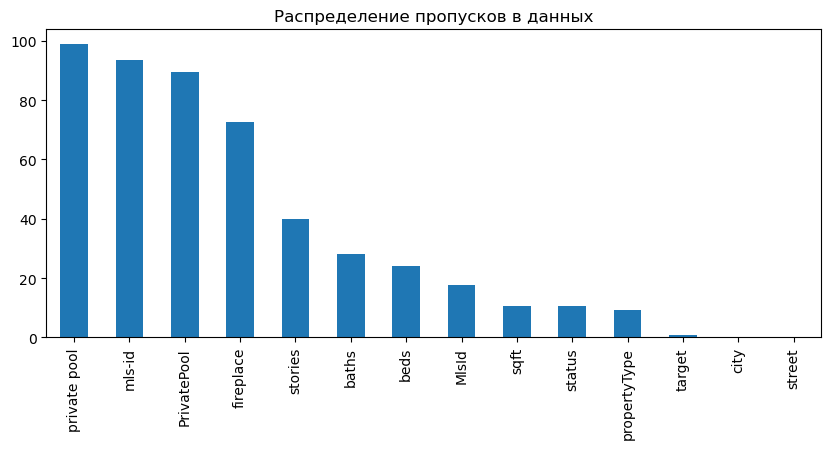

In [5]:
cols_null_percent = df.isnull().mean() * 100 # считаем в %%
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False) # сотируем по убыванию
#display(cols_with_null)

cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

"наиболее пустые" столбцы:
* private pool    98.9%
* mls-id          93.4%
* PrivatePool     89.3%
* fireplace       72.7%
* stories         39.9%
* baths           28.2%
* beds            24.2%
* MlsId           17.7%

Кроме того, столбец `df['target']` тоже имеет пустые зачения. Отсутствие цены в сведениях об объекте недвижимости делает остальные данные в таких строках для нас соверешенно бесполезными, избавимся от них в первую очередь. Также приведем признак `df['target']` к числовому формату

In [6]:
df['target'] = pd.to_numeric(df['target'].str.replace('\D', ''), errors='coerce')

C:\Users\w10\AppData\Local\Temp\ipykernel_182744\96006923.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['target'] = pd.to_numeric(df['target'].str.replace('\D', ''), errors='coerce')
C:\Users\w10\AppData\Local\Temp\ipykernel_182744\96006923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = pd.to_numeric(df['target'].str.replace('\D', ''), errors='coerce')


In [7]:
# удалим строки, не содержащие сведения о цене
print('Нет сведений о цене: ', df['target'].isnull().sum()) # Сколько всего в таблице пропущенных значений
df = df[df['target'].notna()] 
print(f'Результирующее число записей: {df.shape[0]}')

Нет сведений о цене:  2480
Результирующее число записей: 374655


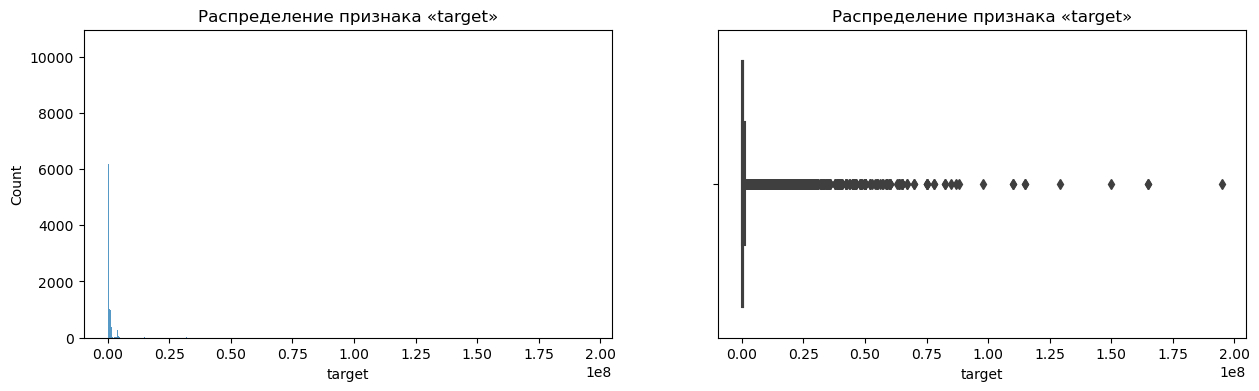

In [8]:
# посмотрим на распределение целевого признака

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='target', ax=axes[0]);
histplot.set_title('Распределение признака «target»');
# histplot.axvline(df_v14['target'].mean(), color='red', lw=2)

boxplot = sns.boxplot(data=df, x='target', ax=axes[1]);
boxplot.set_title('Распределение признака «target»');

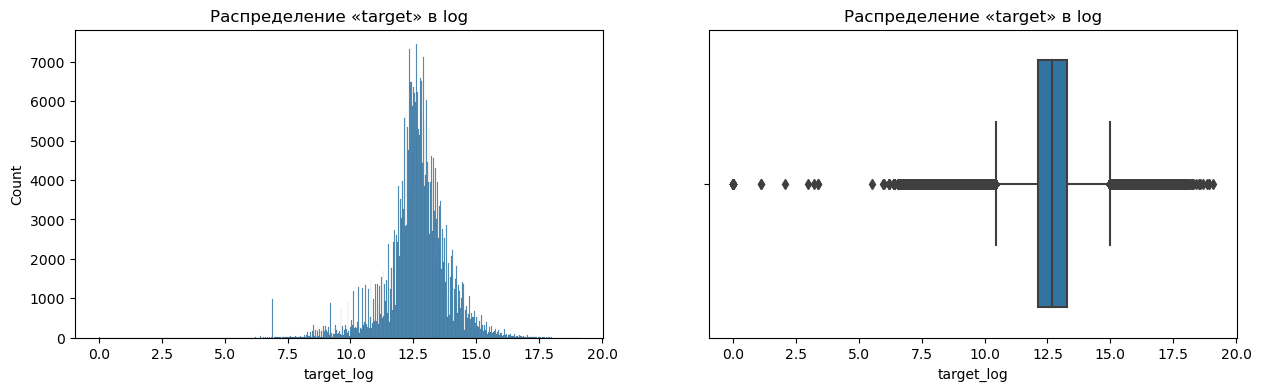

In [9]:
# посмотрим на распределение целевого признака в логарифмическом масштабе

df['target_log'] = np.log(df['target']) # смысла прибавлять +1 нету, т.к. нулевых значений нет

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='target_log', ax=axes[0]);
histplot.set_title('Распределение «target» в log');
boxplot = sns.boxplot(data=df, x='target_log', ax=axes[1]);
boxplot.set_title('Распределение «target» в log');

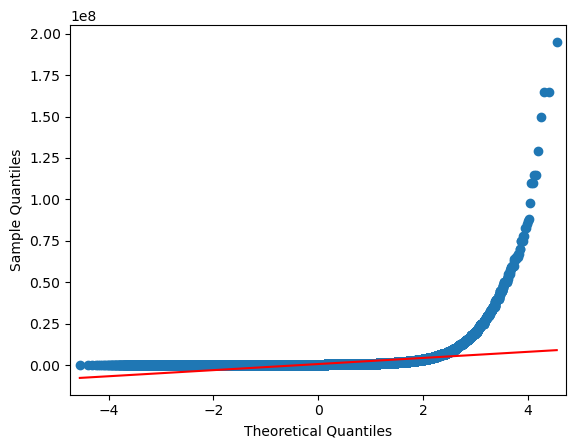

In [10]:
from scipy import stats
import statsmodels.api as sm
fig = sm.qqplot(df['target'], line='s')
plt.show()

Таким образом, набор данных не соответствует нормальному распределению в районе правого хвоста.
То есть по графическим тестам мы можем сказать, что данные не имеют нормального распределения. Тесты проведем после завершения очистки

### 18 признаков, указанных в df содержат следующие сведения об объектах  недвижимости:
###### Местонахождение объекта недвижимости
* Улица `df['street']`
* Индекс `df['zipcode']`
* Город `df['city']`
* Штат `df['state']`

###### Оснащение объекта недвижимости
* Бассейн `df['PrivatePool']` и `df['private pool']`
* Камин `df['fireplace']`
* Ванны `df['baths']`
* Спальни `df['beds']`
* Этажность `df['stories']`
* Площадь `df['sqft']`

###### Какие-то неопределенные признаки, с информативностью которых надо разобраться:
* дублирующиеся `df['mls-id']` и `df['MlsId']`
* `df['status']`
* `df['propertyType']`
* `df['homeFacts']`
* `df['schools']`

###### Целевой признак:
* Цена `df['target']`

После удаления дубликатов и строк, не имеющих сведений о цене объекта недвижимости, у нас осталось 374 655 объектов недвижимости

## Начнем очистку с неопреденных признаков
#### Признаки `"mls-id"` и `"MlsId"` 
содержат много пропусков и имеют похожее название. Определимся с ними - есть ли смысл обрабатывать эти данные (объединять данные в один признак) или они полностью дублируются и один из столбцов не несет дополнительной информации.

In [11]:
# Определяемся с признаками MlsId и mls-id
#доля уникальных значений от размера признака
nunique_MlsId = round(df['MlsId'].nunique() / df['MlsId'].count()*100,2)
nunique_mls = round(df['mls-id'].nunique() / df['mls-id'].count()*100,2)
print(f'MlsId Количество уникальных значений: {nunique_MlsId}%')
print(f'mls-id Количество уникальных значений: {nunique_mls}%')

MlsId Количество уникальных значений: 75.08%
mls-id Количество уникальных значений: 99.86%


Столбец `df['mls-id']` на 99,9% состоит из уникальных значений, что говорит о его неинформативности для ML, его можно будет удалить. Столбец `df['MlsId']` не такой уникальный, посмотрим на него внимательнее:

In [12]:
df['MlsId'].value_counts().head(20)

NO MLS                        24
No MLS #                      16
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
 B, Houston, TX 77008          9
 1, South Boston, MA 02127     9
No                             9
 2, Washington, DC 20002       8
 11A, Orlando, FL 32833        8
No mls                         8
 B, Houston, TX 77007          8
 2, Washington, DC 20010       7
 1, Washington, DC 20002       7
 A, Austin, TX 78721           6
 1, Washington, DC 20010       6
 2, Washington, DC 20001       6
2088662                        6
 1A, Orlando, FL 32833         6
 0, Doral, FL 33178            6
 A, Austin, TX 78704           6
Name: MlsId, dtype: int64

Значения столбца `df['MlsId']` больше похожи на сведения, которые должны содержаться в столбцах:
* `df['city']`
* `df['state']`
* `df['zipcode']`

In [13]:
city_0 = df['city'].isnull().sum()
state_0 = df['state'].isnull().sum()
zipcode_0 = df['zipcode'].isnull().sum()
print(f'количество пустых значний в zipcode: {zipcode_0}')
print(f'количество пустых значний в city: {city_0}')
print(f'количество пустых значний в state: {state_0}')

количество пустых значний в zipcode: 0
количество пустых значний в city: 34
количество пустых значний в state: 0


Поскольку в столбцах Штат `df['state']` и Индекс `df['zipcode']` нет пустых значений, которые можно было бы заполнить, используя сведения из столбца `df['MlsId']`, проверим можно ли заполнить пустые значения в столбце Город `df['city']`

In [14]:
mask1 = df['city'].isnull()
df_new = df[['city', 'MlsId']]
display(df_new[mask1])


,city,MlsId
7830,NaN,A10445273
21529,NaN,F10183087
26467,NaN,20183582
60994,NaN,F10011873
81514,NaN,A10652556
122345,NaN,A10697411
123490,NaN,A10326590
130563,NaN,NaN
131275,NaN,A10741077
151965,NaN,F10011860


Восполнить пустые значения `df['city']` из `df['MlsId']` не получится - названий городов в нужных нам строках нет.  
Таким образом, признак `df['MlsId']` можно будет также удалить, он не может использоваться для обучения модели.


#### Рассмотрем содержание остальных неопределенных признаков

In [15]:
df[['status', 'schools', 'homeFacts', 'propertyType']].describe()

,status,schools,homeFacts,propertyType
count,335399,374655,374655,340101
unique,156,295362,318850,1279
top,for sale,"[{'rating': [], 'data': {'Distance': [], 'Grad...","{'atAGlanceFacts': [{'factValue': '', 'factLab...",single-family home
freq,156054,4177,7142,91370


#### Признак `df['status']`

In [16]:
nunique_status = round(df['status'].nunique() / df['status'].count()*100,2)
print(f'status\n Количество уникальных значений: {nunique_status} %')
top_freq_status = df['status'].value_counts(normalize=True).max()
print(f' {round(top_freq_status*100, 2)}% одинаковых значений')
df['status'].value_counts().head(60)

status
 Количество уникальных значений: 0.05 %
 46.53% одинаковых значений


for sale                             156054
Active                               105206
For sale                              43464
foreclosure                            5677
New construction                       5458
Pending                                4697
Pre-foreclosure                        2000
P                                      1488
Pre-foreclosure / auction              1281
Under Contract Show                    1183
 / auction                              799
Under Contract   Showing                793
Active Under Contract                   718
New                                     690
Under Contract                          690
Contingent                              581
Price Change                            563
Auction                                 493
A Active                                443
for rent                                398
Foreclosure                             343
Foreclosed                              294
Under Contract Backups          

Возможно, цена объекта со статусом "Аукцион" или "Лишение права выкупа" существенно отличается от простой "For sale" но учесть это не представляется возможным, поэтому считаю необходимым удалить только 398 строк "for rent", и 18 строк 'Lease' поскольку арендндная плата по определению отличается от цены объекта. После удаления этих строк, столбец `df['status']` можно будет удалить.

In [17]:
df.drop(df[df['status'].str.contains('rent', na=False)].index, inplace = True)
df.drop(df[df['status'].str.contains('Lease', na=False)].index, inplace = True)
print(f'Результирующее число записей: {df.shape[0]}')

Результирующее число записей: 374239


#### Признаки `df['schools']` и `df['homeFacts']`
состоят из списков значений каждый и не имеют пропусков данных - это должно быть интересно, посмотрим их содержание:

In [18]:
nunique_schools = round(df['schools'].nunique() / df['schools'].count()*100,2)
print(f'schools\n Количество уникальных значений: {nunique_schools} %')
top_freq_schools = df['schools'].value_counts(normalize=True).max()
print(f' {round(top_freq_schools*100, 2)}% одинаковых значений')

nunique_homeFacts = round(df['homeFacts'].nunique() / df['homeFacts'].count()*100,2)
print(f'homeFacts\n Количество уникальных значений: {nunique_homeFacts} %')
top_freq_homeFacts = df['homeFacts'].value_counts(normalize=True).max()
print(f' {round(top_freq_homeFacts*100, 2)}% одинаковых значений')

schools
 Количество уникальных значений: 78.84 %
 1.11% одинаковых значений
homeFacts
 Количество уникальных значений: 85.13 %
 1.91% одинаковых значений


In [19]:
new_home_facts_cols = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for index, col in enumerate(new_home_facts_cols):
    df[col] = df['homeFacts'].apply(lambda x: eval(x).get('atAGlanceFacts')[index].get('factValue'))

In [20]:
# Год постройки
df['Year built'].value_counts(normalize=True)

        0.157737
2019    0.086689
2006    0.021431
2005    0.020082
2007    0.019100
          ...   
1740    0.000003
1845    0.000003
1208    0.000003
1823    0.000003
1804    0.000003
Name: Year built, Length: 228, dtype: float64

In [21]:
# Год реконструкции
df['Remodeled year'].value_counts(normalize=True)

        0.569341
2006    0.015789
2005    0.013728
2007    0.012518
2008    0.010816
          ...   
1888    0.000003
1800    0.000003
1738    0.000003
1869    0.000003
1862    0.000003
Name: Remodeled year, Length: 154, dtype: float64

In [22]:
# Отопление
df['Heating'].value_counts(normalize=True)

                                                                0.282934
Forced Air                                                      0.222126
Forced air                                                      0.137854
Other                                                           0.078365
Electric                                                        0.027422
                                                                  ...   
Central, Exhaust Fans, Natural Gas, Zoned                       0.000003
BR Closet-Electric - new                                        0.000003
Wood Stove                                                      0.000003
Electric, Oil, Propane                                          0.000003
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor    0.000003
Name: Heating, Length: 1972, dtype: float64

In [23]:
# Охлаждение
df['Cooling'].value_counts(normalize=True)

Central                                                                               0.425139
                                                                                      0.321383
Central Air                                                                           0.038791
No Data                                                                               0.028037
Has Cooling                                                                           0.026241
                                                                                        ...   
Air Conditioning-Room, Evaporative Cooler (Swamp)                                     0.000003
Central Air, Electric Hot Air, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat    0.000003
Forced Air Heating, Radiator Heat, Wall Heat                                          0.000003
Air Conditioning, Dual                                                                0.000003
Central A/C (Gas), Central Heat (Gas), Heat Pump  

In [24]:
# Парковка
df['Parking'].value_counts(normalize=True)

                                                                                                                                    0.460642
Attached Garage                                                                                                                     0.189452
2 spaces                                                                                                                            0.075152
1 space                                                                                                                             0.038036
Detached Garage                                                                                                                     0.035312
                                                                                                                                      ...   
Boat, Driveway, Garage Door Opener, Garage Faces Rear, Oversized, Workshop in Garage                                                0.000003
Assigned, Ope

In [25]:
# размер партии
df['lotsize'].value_counts(normalize=True)

                  0.093777
—                 0.072771
No Data           0.015301
-- sqft lot       0.011019
0.26 acres        0.007170
                    ...   
5750 sqft         0.000003
6,816 Sq. Ft.     0.000003
8,762 sqft        0.000003
21523             0.000003
7,084 sqft lot    0.000003
Name: lotsize, Length: 37332, dtype: float64

In [26]:
# Цена/квадратный фут
df['Price/sqft'].value_counts(normalize=True)

                   0.014418
No Data            0.003345
$1/sqft            0.003068
No Info            0.002993
$125/sqft          0.002504
                     ...   
$1328 / Sq. Ft.    0.000003
$1,429             0.000003
$1478 / Sq. Ft.    0.000003
$3,926             0.000003
$2,032             0.000003
Name: Price/sqft, Length: 6500, dtype: float64

При подробном изучении признаков `df['schools']` и `df['homeFacts']` выявил, что хотя пропусков в данных нет, очень много строк заполнено пробелами, прочерками или "No Data" в разных вариациях. Если бы указанные данные были более полными, некоторые из них было бы интересно включить в расчет цены, но с учетом большого количества пробелов придется их удалить (подробности `df['schools']` не стал здесь приводить - на моем компьютере это очень долго выполняется).

In [27]:
# на всякий случай, вдруг понадобятся, сохраним расширенные данные
backup_full = df.copy()
backup_full.to_csv("data/backup_full.csv") # запись
backup_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374239 entries, 0 to 377184
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          334983 non-null  object 
 1   private pool    4151 non-null    object 
 2   propertyType    339685 non-null  object 
 3   street          374237 non-null  object 
 4   baths           268989 non-null  object 
 5   homeFacts       374239 non-null  object 
 6   fireplace       102422 non-null  object 
 7   city            374205 non-null  object 
 8   schools         374239 non-null  object 
 9   sqft            334164 non-null  object 
 10  zipcode         374239 non-null  object 
 11  beds            283357 non-null  object 
 12  state           374239 non-null  object 
 13  stories         224898 non-null  object 
 14  mls-id          24937 non-null   object 
 15  PrivatePool     40023 non-null   object 
 16  MlsId           309926 non-null  object 
 17  target    

data = pd.read_csv("data/backup_full.csv")
df = data.copy()
df.info()

In [55]:
# удаляю осмотренные столбцы
df.drop(['mls-id', 'MlsId', 'homeFacts', 'schools',  #'Unnamed: 0',
         'Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft', 
         ], axis = 1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333353 entries, 0 to 377184
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   status                 297453 non-null  object 
 1   city                   333320 non-null  object 
 2   sqft                   333353 non-null  float64
 3   zipcode                333353 non-null  object 
 4   state                  333353 non-null  object 
 5   target                 333353 non-null  float64
 6   propertyType_cat_temp  333353 non-null  object 
 7   PrivatePool_cat        333353 non-null  int64  
 8   fireplace_cat          333353 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 25.4+ MB


#### Признак `df['propertyType']`

In [29]:
nunique_propertyType = round(df['propertyType'].nunique() / df['propertyType'].count()*100,2)
print(f'propertyType\n Количество уникальных значений: {nunique_propertyType} %')
top_freq_propertyType = df['propertyType'].value_counts(normalize=True).max()
print(f' {round(top_freq_propertyType*100, 2)}% одинаковых значений')
df['propertyType'].value_counts().head(20)

propertyType
 Количество уникальных значений: 0.38 %
 26.83% одинаковых значений


single-family home               91153
Single Family                    61886
Single Family Home               31721
condo                            25874
lot/land                         20506
Condo                            16487
townhouse                        11388
Land                             10933
multi-family                      7742
Condo/Townhome/Row Home/Co-Op     7701
Townhouse                         6909
Traditional                       5912
coop                              3264
Multi Family                      2769
High Rise                         1823
Ranch                             1781
Detached, One Story               1614
mobile/manufactured               1613
Single Detached, Traditional      1581
Contemporary                      1556
Name: propertyType, dtype: int64

Признак `df['propertyType']` содержит множество повторяющихся в разном виде типов недвижимости. Предположу (гипотеза), что тип недвижимости существенно влияет на ее стоимость, поэтому попробую объединить типы в более крупные кластеры с одинаковым названием.

In [30]:
df['propertyType'] = df['propertyType'].str.replace(r'single-family home', 'Single Family')
df['propertyType'] = df['propertyType'].str.replace(r'Single Family Home', 'Single Family')
df['propertyType'] = df['propertyType'].str.replace(r'SingleFamilyResidence', 'Single Family')

df['propertyType'] = df['propertyType'].str.replace(r'condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo/Townhome/Row Home/Co-Op', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'coop', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Cooperative', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo/Townhome', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo/Townhome, Traditional', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo/Townhome, Contemporary/Modern', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Contemporary/Modern', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Traditional', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level), Contemporary', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level)', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level), Contemporary', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level)', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo/Unit', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Contemporary', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Contemporary/Modern', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Contemporary/Modern, Traditional', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'2 Stories, Contemporary', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level), Contemporary', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level)', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'1 Story, Contemporary', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo/Modern, Traditional', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'2 Stories, Condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Urban Condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level), Condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level)', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'1 Story, Condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo/Modern', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level), Condo ', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level) ', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Traditional', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo (Single Level), Condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo (Single Level)', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Mediterranean', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Co-op', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Ranch', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo (Single Level), Condo  ', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo (Single Level)  ', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Attached or 1/2 Duplex, Condo', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Traditional', 'Condo')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Mid-Century Modern', 'Condo')

df['propertyType'] = df['propertyType'].str.replace(r'townhouse', 'Townhouse')
df['propertyType'] = df['propertyType'].str.replace(r'Townhouse, Modern', 'Townhouse')

df['propertyType'] = df['propertyType'].str.replace(r'lot/land', 'Land')

df['propertyType'] = df['propertyType'].str.replace(r'multi-family', 'Multi Family')
df['propertyType'] = df['propertyType'].str.replace(r'Multi-Family Home', 'Multi Family')

df['propertyType'] = df['propertyType'].str.replace(r'Detached, One Story', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Traditional', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Detached, Two Story', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Contemporary/Modern', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Detached', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Spanish/Mediterranean', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Single Detached', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Single Detached, Craftsman', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Craftsman', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Tudor', 'Single Detached')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Mid-Century Modern', 'Single Detached')

df['propertyType'] = df['propertyType'].str.replace(r'Farms/Ranches', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Ranch, Traditional', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Ranch', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Ranch, One Story', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Detached, Ranch, One Story', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Single Ranch', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Condo, Ranch', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Florida, Ranch', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Florida', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'1 Story, Ranch', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Rancher', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Custom, Ranch', 'Ranch')
df['propertyType'] = df['propertyType'].str.replace(r'Farmhouse', 'Ranch')

df['propertyType'] = df['propertyType'].str.replace(r'Mfd/Mobile Home', 'Mfd/Mobile')
df['propertyType'] = df['propertyType'].str.replace(r'mobile/manufactured', 'Mfd/Mobile')
df['propertyType'] = df['propertyType'].str.replace(r'Mfd/Mobile Home', 'Mfd/Mobile')
df['propertyType'] = df['propertyType'].str.replace(r'Mobile / Manufactured', 'Mfd/Mobile')

df['propertyType'] = df['propertyType'].str.replace(r'High Rise, High Rise', 'High Rise')
df['propertyType'] = df['propertyType'].str.replace(r'High Rise, Split-Level', 'High Rise')
df['propertyType'] = df['propertyType'].str.replace(r'Split-Level', 'High Rise')
df['propertyType'] = df['propertyType'].str.replace(r'Split Level', 'High Rise')
df['propertyType'] = df['propertyType'].str.replace(r'High Rise, Penthouse', 'High Rise')
df['propertyType'] = df['propertyType'].str.replace(r'High-Rise (8+ Stories)', 'High Rise')
df['propertyType'] = df['propertyType'].str.replace(r'Penthouse', 'High Rise')
df['propertyType'] = df['propertyType'].str.replace(r'High-Rise (8+ Stories) ', 'High Rise')

df['propertyType'] = df['propertyType'].str.replace(r'2 Stories, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'1 Story, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Colonial', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Traditional, Transitional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Transitional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Ranch, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Traditional, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Mediterranean, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Other Style, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Craftsman, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'French, Traditional', 'Traditional')
df['propertyType'] = df['propertyType'].str.replace(r'Single Detached, Traditional', 'Traditional')

df['propertyType'] = df['propertyType'].str.replace(r'1 Story', 'One Story')
df['propertyType'] = df['propertyType'].str.replace(r'1 Story with Basement', 'One Story')

df['propertyType'] = df['propertyType'].str.replace(r'2 Stories', 'Two Stories')
df['propertyType'] = df['propertyType'].str.replace(r'Two Story', 'Two Stories')
df['propertyType'] = df['propertyType'].str.replace(r'2 Story', 'Two Stories')
df['propertyType'] = df['propertyType'].str.replace(r'Low-Rise (1-3 Stories)', 'Two Stories')

df['propertyType'] = df['propertyType'].str.replace(r'apartment', 'Apartment')
df['propertyType'] = df['propertyType'].str.replace(r'Bungalow, Cape Cod', 'Bungalow')

C:\Users\w10\AppData\Local\Temp\ipykernel_182744\1636941264.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level), Contemporary', 'Condo')
C:\Users\w10\AppData\Local\Temp\ipykernel_182744\1636941264.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level)', 'Condo')
C:\Users\w10\AppData\Local\Temp\ipykernel_182744\1636941264.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(r'Condominium (Single Level), Contemporary', 'Condo')
C:\Users\w10\AppData\Local\Temp\ipykernel_182744\1636941264.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.

In [31]:
# УКРУПНЕННЫЕ 14 ТИПОВ НЕДВИЖИМОСТИ:
print(df['propertyType'].value_counts().head(14).sum() / len(df['propertyType']))
df['propertyType'].value_counts().head(14)

0.8873019647872081


Single Family      184939
Condo               58139
Land                31439
Townhouse           18377
Multi Family        12012
Traditional          8596
Single Detached      4924
Mfd/Mobile           3460
Ranch                3397
High Rise            2152
One Story            1826
Two Stories          1504
Apartment             790
Bungalow              508
Name: propertyType, dtype: int64

В результате приведения типов недвижимости в df к унифицированным названиям, нам удалось объеденить сведения о 90% имеющихся объектов недвижимости, в df в 14 групп.  
Если собрать остальные объекты в тип "Other", но туда попадут и "Multiple Occupancy" многоквартирные дома и "Two Stories, Mediterranean" средиземноморские двухэтажки, и многое другое - то есть совершенно разные типы, с небольшим количеством сведений о каждом. Такой "сборник" будет состоять из одних выбросов, или из очень широкого диапозона площадей и цен. Думаю, лучше от них просто избавиться, поскольку пользы для прогнозирования цен на недвижимость такие разрозненные сведения принести не могут. Но пока это только гипотеза, поэтому сделаю строки с типом "Other" - удалить никогда не поздно.

In [32]:
def propertyType_(stroka):
    if stroka == 'Single Family':
        return 'Single Family'
    elif stroka == 'Condo':
        return 'Condo'
    elif stroka == 'Land':
        return 'Land'
    elif stroka == 'Townhouse':
        return 'Townhouse'
    elif stroka == 'Multi Family':
        return 'Multi Family'
    elif stroka == 'Traditional':
        return 'Traditional'
    elif stroka == 'Single Detached':
        return 'Single Detached'
    elif stroka == 'Mfd/Mobile':
        return 'Mfd/Mobile'
    elif stroka == 'Ranch':
        return 'Ranch'
    elif stroka == 'High Rise':
        return 'High Rise'
    elif stroka == 'One Story':
        return 'One Story'
    elif stroka == 'Two Stories':
        return 'Two Stories'
    elif stroka == 'Apartment':
        return 'Apartment'
    elif stroka == 'Bungalow':
        return 'Bungalow'
    else:
        return 'Other'
    
df['propertyType_cat_temp'] = df['propertyType'].apply(propertyType_)
df['propertyType_cat_temp'].value_counts(normalize=True)*100

Single Family      49.417351
Condo              15.535260
Other              11.269804
Land                8.400781
Townhouse           4.910498
Multi Family        3.209714
Traditional         2.296928
Single Detached     1.315737
Mfd/Mobile          0.924543
Ranch               0.907709
High Rise           0.575034
One Story           0.487923
Two Stories         0.401882
Apartment           0.211095
Bungalow            0.135742
Name: propertyType_cat_temp, dtype: float64

## Признаки местонахождения объекта недвижимости
записаны в четырех столбцах:
* Штат `df['state']`
* Город `df['city']`
* Индекс `df['zipcode']`
* Улица `df['street']`


In [33]:
df[['state', 'city', 'zipcode', 'street']].describe()

,state,city,zipcode,street
count,374239,374205,374239,374237
unique,39,2019,4541,334429
top,FL,Houston,32137,Address Not Disclosed
freq,114548,24387,2139,672


В признаке Улица есть небольшое количество пропусков, посмотрим можно ли заполнить пропуски и нужно ли это делать.

In [34]:
nunique_street = round(df['street'].nunique() / df['street'].count()*100,2)
print(f'street Количество уникальных значений: {nunique_street} %')
df['street'].value_counts().head()

street Количество уникальных значений: 89.36 %


Address Not Disclosed    672
Undisclosed Address      516
(undisclosed Address)    391
Address Not Available    175
Unknown Address           72
Name: street, dtype: int64

Признак Улица имеет большой процент уникальных значений, а если удалить наиболее распространенные "адрес не разглашается" и "Адрес неизвестен", то процент уникальных значений станет еще больше. Считаю указанный признак неинформативным, его необходимо удалить.

Описание признаков Город и Штат говорит о том, что объекты недвижимости расположены в 39 штатах и 2019 городах, при этом почти 30% объектов расположени во Флориде, и большинство из них в Хьюстоне:

Text(0.5, 1.0, 'Распределение недвижимости по городам')

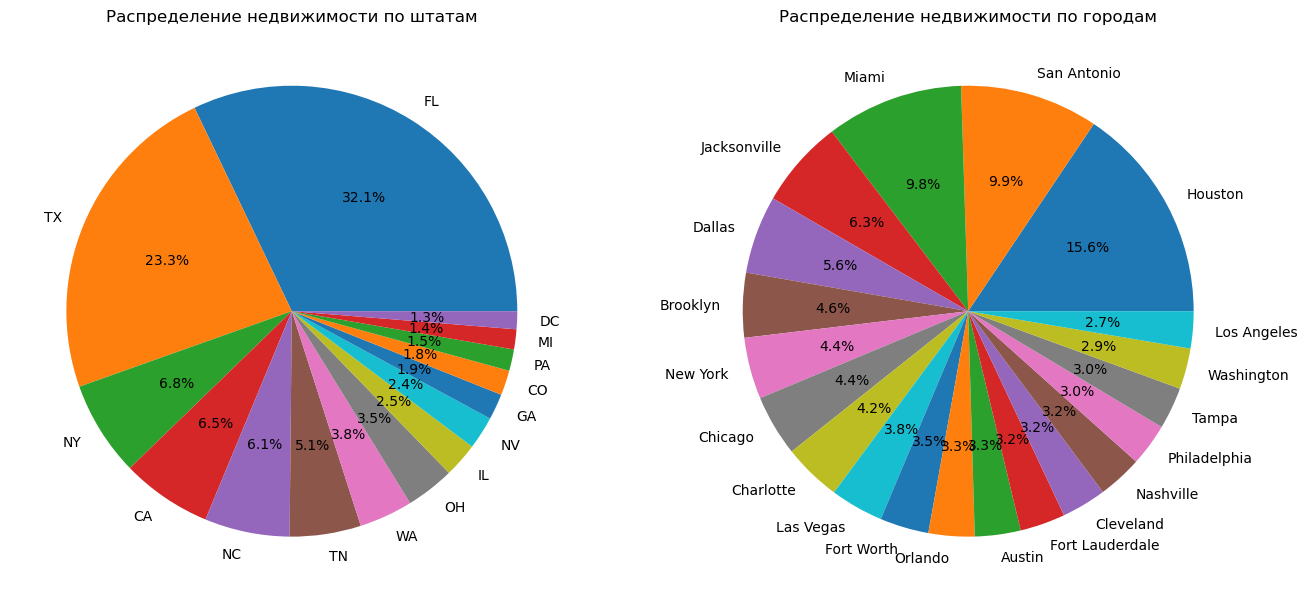

In [35]:
states = df['state'].value_counts()[:15]
cites = df['city'].value_counts()[:20]

#визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

axes[0].pie(states, labels=states.index, autopct='%.1f%%');
axes[0].set_title('Распределение недвижимости по штатам')

axes[1].pie(
    cites,
    labels=cites.index,
    autopct='%.1f%%'
);
axes[1].set_title('Распределение недвижимости по городам')


Есть интересный признак `df['zipcode']`, который исходя из его смысла, также может служить признаком местанахождения объекта недвижимости. Сравнив количество уникальных значений в столбцах `df['zipcode']` и `df['city']` видим, что количество уникальных Индексов более чем в два раза превышает количество Городов, это значит, что Индекс учитывает более точное указание местонахождения, хотя и не такое детальное как Улица. Этот признак оставим для учета местонахождения объекта недвижимости при прогнозировании цены, поскольку местонахождение недвижимости должно учитыаться в цене, а Индекс - более детально учитывает этот фактор чем Штат и Город, при этом - достаточно укрупненно, хотя есть и множество единичных значений

### Вывод по признакам о местонахождении объектов недвижимости:
Поскольку df содержит данные из более чем 2000 городов, а сведения об улицах почти все уникальны, для модели прогнозирования цены, необходимо укрупнять кластеры объектов недвижимости. 

Есть интересный признак `df['zipcode']`, который исходя из его смысла, также может служить признаком местанахождения объекта недвижимости. Сравнив количество уникальных значений в столбцах `df['zipcode']` и `df['city']` видим, что количество уникальных Индексов более чем в два раза превышает количество Городов, это значит, что Индекс учитывает более точное указание местонахождения, хотя и не такое детальное как Улица. Этот признак оставим для учета местонахождения объекта недвижимости при прогнозировании цены, поскольку местонахождение недвижимости должно учитыаться в цене, а Индекс - более детально учитывает этот фактор чем Штат и Город, при этом - достаточно укрупненно, хотя есть и множество единичных значений

Считаю возможным использовать для определения признака местонаходения объекта недвижимости столбец Индекс `df['zipcode']`. Остальные столбцы Штат `df['state']`, Город `df['city']`, Улица `df['street']` можно будет удалить

## Признаки оснащения объекта недвижимости


#### Определяемся с признаком "частный бассейн"
Указанный признак имееет больше всего прропусков, кроме того, сведения о частном бассейне дублируются в df в двух столбцах с похожим названием: `"private pool"` и `"PrivatePool"`.  
Определимся с ними - есть ли смысл обрабатывать эти данные (объединять данные в один столбец), или они дублируются и один из столбцов не несет дополнительной информации

In [36]:
display(df['private pool'].value_counts())
display(df['PrivatePool'].value_counts())

Yes    4151
Name: private pool, dtype: int64

yes    28591
Yes    11432
Name: PrivatePool, dtype: int64

Признак "частный бассейн" в обоих столбцах содержит только два варианта занчений: Yes(yes) или NaN, считаю возможным объеденить два столбца в один, преобразовав значения:
* Yes(yes) = 1 
* NaN = 0  
второй столбец - удалить

In [37]:
def refund_(stroka):
    if stroka == 'Yes':
        return 1
    elif stroka == 'yes':
        return 1
    else:
        return 0
df['PrivatePool'] = df['PrivatePool'].apply(refund_)
df['private pool'] = df['private pool'].apply(refund_)
df['PrivatePool_cat'] = df['private pool'] + df['PrivatePool']
df['PrivatePool_cat'].value_counts()
df.drop(['private pool'], axis = 1, inplace=True)
df.drop(['PrivatePool'], axis = 1, inplace=True)
df['PrivatePool_cat'].value_counts()

0    330065
1     44174
Name: PrivatePool_cat, dtype: int64

##### Признак `df['fireplace']` "камин" содержит множество уникальных занчений:

In [38]:
nunique_fireplace = round(df['fireplace'].nunique() / df['fireplace'].count()*100,2)
print(f'fireplace Количество уникальных значений: {nunique_fireplace} %')
df['fireplace'].value_counts()#.head(60)

fireplace Количество уникальных значений: 1.61 %


yes                                                                     49922
Yes                                                                     20619
1                                                                       14533
2                                                                        2432
Not Applicable                                                           1990
                                                                        ...  
Gas, Wood Burning, Two, Propane Logs Convey                                 1
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: fireplace, Length: 1652, dtype: int64

Судя по уникальным значениям, отсутсвие камина (кроме варианта с пустой строкой) может быть помечено "no" или "0" или "N/K", 
а наличие камина обозначается либо цифрой - количество каминов (1 - 5), либо местонахождением камина (указнием на комнату), либо используемым топливом (газ/дрова), либо Yes(yes).  
Хотя сведения о камине есть менее чем в 27% строк (домов), возможно его наличие влияет на стоимость объекта недвижимости, поэтому считаю необходимым преобразовать данный признак, обозначив "0" - отсутсвие камина (как и отсутсвие сведений о камине), а наличие камина(ов), независимо от вида топлива обозначить числом от 1 до 5 - по количеству, указанному в столбце.

In [39]:
df['fireplace_cat'] = (np.where(df['fireplace'].isnull(), 0,1) & 
                       np.where(df['fireplace'] ==  'No', 0,1) & 
                       np.where(df['fireplace'] ==  'N/K', 0,1))
def fireplace_(stroka):
    if stroka == '2':
        return 2
    elif stroka == '3':
        return 3
    elif stroka == '4':
        return 4
    elif stroka =='5':
        return 5
    else:
        return 1
    
df['fireplace_cat_temp'] = df['fireplace'].apply(fireplace_)
df['fireplace_cat_temp'].value_counts()
df['fireplace_cat'] = df['fireplace_cat'] + df['fireplace_cat_temp'] - 1
df.drop(['fireplace_cat_temp'], axis = 1, inplace=True)
df.drop(['fireplace'], axis = 1, inplace=True)
df['fireplace_cat'].value_counts()


0    272153
1     98842
2      2432
3       563
4       184
5        65
Name: fireplace_cat, dtype: int64

##### Признак `df['baths']` "ванна" содержит несколько уникальных занчений:

In [40]:
nunique_baths = round(df['baths'].nunique() / df['baths'].count()*100,2)
print(f'baths\n Количество уникальных значений: {nunique_baths} %')
print('Пропусков %: ', round(df['baths'].isnull().sum() / df['baths'].count()*100))
df['baths'].value_counts()#.head(60)

baths
 Количество уникальных значений: 0.08 %
Пропусков %:  39


2 Baths          51945
3 Baths          35353
2                20428
2.0              16354
4 Baths          14711
                 ...  
32                   1
5.25 Baths           1
41.0                 1
Bathrooms: 21        1
44.0                 1
Name: baths, Length: 225, dtype: int64

##### Признак `df['beds']` "спальни" содержит несколько уникальных занчений:

In [41]:
nunique_beds = round(df['beds'].nunique() / df['beds'].count()*100,2)
print(f'beds\n Количество уникальных значений: {nunique_beds} %')
print('Пропусков %: ', round(df['beds'].isnull().sum() / df['beds'].count()*100))
df['beds'].value_counts()#.head(60)

beds
 Количество уникальных значений: 0.4 %
Пропусков %:  32


3 Beds        52942
4 Beds        35143
3             31188
2 Beds        26077
4             19915
              ...  
8.93 acres        1
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
8,479 sqft        1
Name: beds, Length: 1146, dtype: int64

Признаки `df['baths']` "ванна" и `df['beds']` "спальни" имеют большое разнообразие значений: где то обозначено их количество, где-то площадь, а также имеется огромное количество пропусков (28% и 24% соответсвенно), что вряд ли говорит об отсутсвии возможности помыться и переночевать. 

Будем исходить из предположения, что в настоящее время каждый объект недвижимости имеет необходимое и достаточное количество спален и ванных комнат. Заполнять указанные признаки придуманными данными смысла нет. Оба признака не буду использовать в дальнейшем обучении модели

##### Посмотрим на признаки `df['stories']` "Этажность" и `df['sqft']` "Площадь" 

In [42]:
df[['stories', 'sqft']].describe()

,stories,sqft
count,224898,334164
unique,348,25369
top,1.0,0
freq,66805,11853


In [43]:
nunique_stories = round(df['stories'].nunique() / df['stories'].count()*100,2)
print(f'stories\n Количество уникальных значений: {nunique_stories} %')
stories_null_percent = round(df['stories'].isnull().mean() * 100,2)
print(f' Количество пропусков: {stories_null_percent} %')
df['stories'].value_counts()#.head(50)

stories
 Количество уникальных значений: 0.15 %
 Количество пропусков: 39.91 %


1.0                                  66805
2.0                                  55002
1                                    22792
2                                    17976
3.0                                  11230
                                     ...  
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
None                                     1
65.0                                     1
Name: stories, Length: 348, dtype: int64

In [44]:
nunique_sqft = round(df['sqft'].nunique() / df['sqft'].count()*100,2)
print(f'sqft\n Количество уникальных значений: {nunique_sqft} %')
sqft_null_percent = round(df['sqft'].isnull().mean() * 100,2)
print(f' Количество пропусков: {sqft_null_percent} %')
df['sqft'].value_counts()#.head()

sqft
 Количество уникальных значений: 7.59 %
 Количество пропусков: 10.71 %


0                                          11853
1,200 sqft                                   824
1,000 sqft                                   643
1,100 sqft                                   566
1,800 sqft                                   558
                                           ...  
12,160 sqft                                    1
18,400 sqft                                    1
7,162 sqft                                     1
8,210 sqft                                     1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 25369, dtype: int64

Оба признака имеют большое разнообразие значений, а также большое количество пропусков (у этажности - 40%, а у площади - 10,7% пропуски и еще 3,5% обозначены как "0"). Но если признаком этажности можно пожертвовать, то считать стоимость объекта недвижимости без учета его площади будет как минимум странно.  
"Угадывать" площадь объекта недвижимости, в тех случаях когда она прямо не указана, путем заполнения пропусков медианой или средний, считаю бессмысленно, 10,7% (а это - 40122 строк) пропусков придется удалить. Также приведем признак `df['sqft']` к числовому формату

In [45]:
df['sqft'] = pd.to_numeric(df['sqft'].str.replace('\D', ''), errors='coerce')
df['sqft'].value_counts()

C:\Users\w10\AppData\Local\Temp\ipykernel_182744\1442912970.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sqft'] = pd.to_numeric(df['sqft'].str.replace('\D', ''), errors='coerce')


0.0        11853
1200.0      1406
1000.0      1013
1500.0      1010
1800.0       979
           ...  
9268.0         1
8268.0         1
5321.0         1
7116.0         1
13870.0        1
Name: sqft, Length: 9878, dtype: int64

In [46]:
print('Нет сведений о площади: ', df['sqft'].isnull().sum()) # Сколько всего в таблице пропущенных значений
df = df[df['sqft'].notna()] # пока оставил - боюсь попробовать
print(f'Результирующее число записей: {df.shape[0]}')

Нет сведений о площади:  40886
Результирующее число записей: 333353


## Здесь сделаем резрвные копии, 
чтобы удалить лишние на мой взгляд столбцы и посмотреть на выбросы.

* backup - до удаления стобцов
* backup.to_csv("data/backup.csv") - до удаления стобцов сохранил в файл, чтобы в последующим не прогонять весь код


In [56]:
backup = df.copy()
backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333353 entries, 0 to 377184
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   status                 297453 non-null  object 
 1   city                   333320 non-null  object 
 2   sqft                   333353 non-null  float64
 3   zipcode                333353 non-null  object 
 4   state                  333353 non-null  object 
 5   target                 333353 non-null  float64
 6   propertyType_cat_temp  333353 non-null  object 
 7   PrivatePool_cat        333353 non-null  int64  
 8   fireplace_cat          333353 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 25.4+ MB


In [48]:
backup.to_csv("data/backup.csv") # запись

In [ ]:
перечитываем если надо что-то восстановить
#df = pd.read_csv("data/backup.csv")
# df = backup.copy()
df.info()

In [ ]:
# удаляю после сохранения "обреченные" столбцы
df.drop(['propertyType', 'street', 'baths', 'beds', 
#         'status', 'zipcode',  
          'stories'], axis = 1, inplace=True)
# df.drop(['Unnamed: 0'], axis = 1, inplace=True) # необходима только когда из файла читаем заново
df.info()

## Поиск выбросов
Посмотрим на взаимосвязь признаков `df['sqft']` "Площадь" и `df['propertyType']` "Тип недвижимости" и прочих немногих из оставшихся

In [57]:
df

,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat
0,Active,Southern Pines,2900.0,28387,NC,418000.0,Single Family,0,1
1,for sale,Spokane Valley,1947.0,99216,WA,310000.0,Single Family,0,0
2,for sale,Los Angeles,3000.0,90049,CA,2895000.0,Single Family,1,1
3,for sale,Dallas,6457.0,75205,TX,2395000.0,Single Family,0,1
5,for sale,Philadelphia,897.0,19145,PA,209000.0,Townhouse,0,0
...,...,...,...,...,...,...,...,...,...
377179,For sale,Washington,1417.0,20001,DC,799000.0,Condo,0,0
377180,NaN,Miami,4017.0,33180,FL,1249000.0,Single Family,1,0
377181,for sale,Chicago,2000.0,60657,IL,674999.0,Condo,0,0
377182,for sale,Jamaica,1152.0,11434,NY,528000.0,Single Family,0,0


### Определимся с выбросами в указании площади объектов недвижимости

In [51]:
display(df.groupby('propertyType_cat_temp')[['sqft']].describe())

sqft                                              \
                          count          mean           std    min      25%   
propertyType_cat_temp                                                         
Apartment                 757.0  11764.997358  5.694159e+04   22.0   804.00   
Bungalow                  494.0   1435.621457  5.820393e+02  473.0  1058.75   
Condo                   56458.0   4234.825658  2.862043e+04    0.0   910.00   
High Rise                1911.0   1509.653061  9.460689e+02  319.0   963.00   
Land                    15008.0   5727.721282  1.061159e+05    0.0     0.00   
Mfd/Mobile               3252.0   1448.713715  8.505121e+03    0.0  1000.00   
Multi Family            11313.0  43328.363652  4.292859e+06    0.0  1736.00   
One Story                1756.0   1789.589977  8.322969e+02  248.0  1251.50   
Other                   23762.0   2814.074657  2.678915e+04    0.0  1209.00   
Ranch                    3351.0   1855.758878  1.082853e+03    0.0  1296.00   
Single Detached          4735.0   2489.945090  1.537296e+03  520.0  1558.00   
Single Family          182702.0   6781.603360  1.862219e+06    0.0  1500.00   
Townhouse               18031.0   1823.411846  9.685207e+02    1.0  1294.00   
Traditional              8409.0   2502.396004  1.387003e+03  359.0  1586.00   
Two Stories              1414.0   2813.986563  1.312783e+03  527.0  2060.50   

                                                     
                          50%      75%          max  
propertyType_cat_temp                                
Apartment              1075.0  1871.00     605018.0  
Bungalow               1274.0  1643.00       4031.0  
Condo                  1225.0  1756.00     967300.0  
High Rise              1255.0  1703.00      15333.0  
Land                      0.0   738.50    7078574.0  
Mfd/Mobile             1280.0  1534.00     484900.0  
Multi Family           2320.0  3227.00  456602479.0  
One Story              1617.5  2082.00       8266.0  
Other                  1763.0  2610.00    2807917.0  
Ranch                  1744.0  2265.00      30000.0  
Single Detached        2085.0  2940.00      18359.0  
Single Family          2048.0  2838.00  795979430.0  
Townhouse              1648.0  2101.00      30000.0  
Traditional            2210.0  3054.00      15100.0  
Two Stories            2554.5  3187.75      12082.0

#### наблюдения:
* в df есть объекты недвижимости с площадью == 0
* 25-й квантиль составляет минимум 803 sqft (это 74 кв.м - для себя посчитал), посмотрим на количество и состав объектов, меньше 500 sqft (46.5 кв.м)
* в df есть объеты с площадью < 1 млн sqft (92000 кв.м), посмотрим на их состав
* 75-й квантиль составляет максимум 3331.50 квадрата (в Типе "Land"), посмотрим на количество и состав объектов, больше 50000 sqft (4600 кв.м)

In [52]:
sqft_0 = df[df['sqft'] == 0]['propertyType_cat_temp'].value_counts().sum()
print(f'Количество объектов S = 0: {sqft_0}')

Количество объектов S = 0: 11853


In [58]:
mask_sqft_0 = df['sqft'] == 0
df[mask_sqft_0].sort_values(by=['target'])#.head(50)

,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat
271049,Active,Pataskala,0.0,43062,OH,1.0,Land,0,0
205356,Active,Huntley,0.0,60142,IL,1.0,Land,0,0
148240,Active,Huntley,0.0,60142,IL,1.0,Land,0,0
320807,Active,Amanda,0.0,43102,OH,1.0,Land,0,0
334151,Active,Abingdon,0.0,24210,VA,400.0,Land,0,0
...,...,...,...,...,...,...,...,...,...
33701,Active,Los Angeles,0.0,90069,CA,25500000.0,Single Family,0,1
155016,Active,Nashville,0.0,37221,TN,32500000.0,Ranch,0,0
145652,Active,Pataskala,0.0,43062,OH,34611750.0,Land,0,0
77790,Active,Punta Gorda,0.0,33982,FL,50000000.0,Land,0,0


In [59]:
mask_sqft_500 = df['sqft'] < 500
print('Количество объектов <500: ', df[df['sqft'] < 500]['propertyType_cat_temp'].value_counts().sum())
df[df['sqft']  < 500]['propertyType_cat_temp'].value_counts()#.sum()#normalize=True)

Количество объектов <500:  13598


Land             11005
Condo             1176
Single Family      714
Other              212
Ranch              189
Multi Family       168
Mfd/Mobile          79
High Rise           19
Apartment           16
Traditional          8
Townhouse            8
One Story            3
Bungalow             1
Name: propertyType_cat_temp, dtype: int64

In [60]:
print('Количество объектов: ', df[df['sqft'] > 1000000]['propertyType_cat_temp'].value_counts().sum())
df[df['sqft'] > 1000000]['propertyType_cat_temp'].value_counts()#normalize=True)

Количество объектов:  21


Land             16
Single Family     2
Other             2
Multi Family      1
Name: propertyType_cat_temp, dtype: int64

При очистке данных я не стал сразу удалять объекты площадь которых указана как "0", ввиду того, что их было достаточно много (жалко), предпологая, что эти "0" можно будет каким-то образом восполнить. Сейчас мы видим, что "0" стоят в основном у земельных участков, но встречаются у других типов недвижимсти, и несмотря на отсутсвие основной характеристики недвижимости имеют совсем не нулевую стоимость. Восполнить эти данные не получилось, придется удалить

Площадь меньше 500 была указана у 13598 объектов, большая часть из которых "0", после удаления нулевой площади, осталось еще более 1700 обектов, посмотрим их подробнее

Из 21 объекта > 1000000 sqft 16 относятся к земельным участкам, которые не вызывают сомнений, тем не менее, посмотрим и на них

In [61]:
df.drop(df[df['sqft'] ==0].index, inplace = True)
print(f'Результирующее число записей: {df.shape[0]}')

Результирующее число записей: 321500


In [62]:
df[mask_sqft_500].sort_values(by=['sqft'])#.head(50)

C:\Users\w10\AppData\Local\Temp\ipykernel_182744\768478439.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[mask_sqft_500].sort_values(by=['sqft'])#.head(50)


,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat
295098,NaN,Davie,1.0,33324,FL,155000.0,Mfd/Mobile,0,1
353732,for sale,Austin,1.0,78748,TX,639000.0,Land,0,0
296361,for sale,Panama City,1.0,32404,FL,45000.0,Land,0,0
242372,for sale,Chicago,1.0,60660,IL,899900.0,Multi Family,0,0
296670,for sale,Jacksonville,1.0,28540,NC,525000.0,Land,0,0
...,...,...,...,...,...,...,...,...,...
150903,for sale,Long Island City,498.0,11101,NY,610000.0,Condo,0,0
34523,NaN,Orlando,499.0,32835,FL,102000.0,Condo,0,0
146768,for sale,New York,499.0,10016,NY,849500.0,Condo,0,0
267155,foreclosure,New York,499.0,10002,NY,929757.0,Condo,0,0


In [63]:
mask_sqft_bil = df['sqft'] > 1000000
df[mask_sqft_bil].sort_values(by=['sqft'])

,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat
4604,for sale,College Station,1043741.0,77845,TX,1200000.0,Land,0,0
356733,for sale,El Paso,1089000.0,79928,TX,700000.0,Land,0,0
196586,for sale,McAllen,1239282.0,78504,TX,4100000.0,Land,0,0
201106,for sale,Brooksville,1250172.0,34601,FL,1568000.0,Land,0,0
324873,for sale,Syracuse,1417442.0,13215,NY,199900.0,Land,0,0
151007,for sale,Panama City,1524600.0,32404,FL,210000.0,Land,0,0
82469,for sale,Panama City,1598652.0,32409,FL,2500000.0,Land,0,0
323567,for sale,San Antonio,1611720.0,78253,TX,1300000.0,Land,0,0
227446,for sale,Olympia,1761113.0,98502,WA,524700.0,Land,0,0
173320,for sale,Von Ormy,1916640.0,78073,TX,660000.0,Single Family,0,0


Осмотр "мелких" объектов недвижимости обращает внимание на то, что есть множество объектов, чья площадь указана "1", надо проверить иные варианты обозначения площади объекта недвижимости, выходящие за рамки разумного (например до 10 кв.м это примерно 109 sqft), избавимся от них, не имея возможноси определить опечатка это или выброс.

В отношении "крупных" объектов недвижимости вызывает сомнения два объекта (дома!) с площадью 456 и 796 миллионов sqft, имеющие очень скромную цену в 198 и 27,5 тысяч, быстрее всего в каких-то значениях есть опечатка. Чтобы они не искажали прогноз, их проще удалить. 

Осмотр остальных объектов недвижимости не позволяет сделать однозначный вывод, что объекты с условияем  
`'sqft' < 500` или `'sqft' > 1 000 000` являются выбросами. 

In [64]:
mask_sqft_109 = df['sqft'] < 109
print('Количество объектов < 109: ', df[df['sqft'] < 109]['propertyType_cat_temp'].value_counts().sum())
df[df['sqft']  < 109]['propertyType_cat_temp'].value_counts()#.sum()#normalize=True)

Количество объектов < 109:  140


Single Family    43
Land             36
Multi Family     29
Other            15
Condo            10
Mfd/Mobile        4
Townhouse         2
Apartment         1
Name: propertyType_cat_temp, dtype: int64

In [65]:
df.drop(df[df['sqft'] <109].index, inplace = True)
df.drop(df[df['sqft'] >10000000].index, inplace = True)
print(f'Результирующее число записей: {df.shape[0]}')
display(df.groupby('propertyType_cat_temp')[['sqft']].describe())

Результирующее число записей: 321358


sqft                                               \
                          count          mean            std    min      25%   
propertyType_cat_temp                                                          
Apartment                 756.0  11780.530423   56977.685475  350.0   804.75   
Bungalow                  494.0   1435.621457     582.039312  473.0  1058.75   
Condo                   56313.0   4245.723510   28656.443797  120.0   912.00   
High Rise                1911.0   1509.653061     946.068897  319.0   963.00   
Land                     4067.0  21136.228670  203065.003701  140.0  1077.50   
Mfd/Mobile               3230.0   1458.574923    8533.203179  264.0  1008.00   
Multi Family            11165.0   3006.820421    3175.831255  111.0  1763.00   
One Story                1756.0   1789.589977     832.296850  248.0  1251.50   
Other                   23737.0   2817.022665   26803.101437  120.0  1210.00   
Ranch                    3173.0   1959.863851    1016.992600  300.0  1376.00   
Single Detached          4735.0   2489.945090    1537.295539  520.0  1558.00   
Single Family          182169.0   2431.979481    5442.677101  112.0  1504.00   
Townhouse               18029.0   1823.614011     968.384137  110.0  1294.00   
Traditional              8409.0   2502.396004    1387.003107  359.0  1586.00   
Two Stories              1414.0   2813.986563    1312.782529  527.0  2060.50   

                                                   
                          50%      75%        max  
propertyType_cat_temp                              
Apartment              1077.5  1872.00   605018.0  
Bungalow               1274.0  1643.00     4031.0  
Condo                  1227.0  1760.00   967300.0  
High Rise              1255.0  1703.00    15333.0  
Land                   1718.0  3378.50  7078574.0  
Mfd/Mobile             1289.5  1536.00   484900.0  
Multi Family           2340.0  3240.00   126507.0  
One Story              1617.5  2082.00     8266.0  
Other                  1765.0  2612.00  2807917.0  
Ranch                  1792.0  2308.00    30000.0  
Single Detached        2085.0  2940.00    18359.0  
Single Family          2050.0  2841.00  1916640.0  
Townhouse              1648.0  2101.00    30000.0  
Traditional            2210.0  3054.00    15100.0  
Two Stories            2554.5  3187.75    12082.0

#### Вывод про площадь
После удаления очевидных выбросов, описание объектов недвижимости по прежнему свидетельствует о наличии существенных искажений:
минимальная площадь Townhouse, Single Family, Multi Family, Condo, а также объекта из типа Other составляет менее 120 sqft, однако рассматривая данный признак изолировано считаю, что не получится выявить выбросы.
### Посмотрим то же про цену

In [66]:
mask_target_1000 = df['target'] < 1000
print('Количество объектов <1000: ', df[df['target'] < 1000]['propertyType_cat_temp'].value_counts().sum())
df[df['target']  < 1000]['propertyType_cat_temp'].value_counts()#.sum()#normalize=True)

Количество объектов <1000:  27


Land             16
Single Family     6
Condo             2
High Rise         1
Two Stories       1
Multi Family      1
Name: propertyType_cat_temp, dtype: int64

In [67]:
df[mask_target_1000].sort_values(by=['target'])

,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat
15533,Active,Goodlettsville,1596.0,37072,TN,1.0,Single Family,0,0
25334,NaN,Indianapolis,1586.0,46224,IN,1.0,Single Family,0,1
304045,foreclosure,Indianapolis,1586.0,46224,IN,1.0,Single Family,0,1
289162,foreclosure,Goodlettsville,1596.0,37072,TN,1.0,Single Family,0,1
277572,foreclosure,Cincinnati,3226.0,45225,OH,1.0,Multi Family,0,1
256189,NaN,Indianapolis,1780.0,46250,IN,1.0,Condo,0,1
84951,foreclosure,Cincinnati,2536.0,45231,OH,1.0,Land,0,1
252627,Active,Circleville,1771.0,43113,OH,1.0,Two Stories,0,1
321515,foreclosure,Indianapolis,1780.0,46250,IN,1.0,Condo,0,1
212621,foreclosure,Euclid,2402.0,44123,OH,393.0,Single Family,0,1


In [68]:
print('Количество объектов: ', df[df['target'] > 50000000]['propertyType_cat_temp'].value_counts().sum())
df[df['target'] >50000000]['propertyType_cat_temp'].value_counts()#normalize=True)

Количество объектов:  36


Single Family      21
Condo              11
Townhouse           2
Single Detached     1
Land                1
Name: propertyType_cat_temp, dtype: int64

In [69]:
mask_target_bil = df['target'] > 50000000
df[mask_target_bil].sort_values(by=['target'])

,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat
4328,For sale,New York,9607.0,10014,NY,53000000.0,Condo,1,0
258489,Active,Coral Gables,12930.0,33156,FL,55000000.0,Single Detached,0,0
72057,for sale,Coral Gables,12930.0,33156,FL,55000000.0,Single Family,1,1
230699,for sale,Los Angeles,15350.0,90077,CA,55000000.0,Single Family,0,0
176548,NaN,Coral Gables,12930.0,33156,FL,55000000.0,Single Family,1,1
93865,For sale,Los Angeles,18850.0,90049,CA,56000000.0,Single Family,1,0
190987,for sale,New York,7130.0,10019,NY,57000000.0,Condo,1,0
218829,For sale,New York,6234.0,10019,NY,58500000.0,Condo,1,0
169210,for sale,New York,6234.0,10019,NY,58500000.0,Condo,1,0
253888,for sale,New York,10171.0,10001,NY,59000000.0,Condo,1,1


#### Вывод про цену
27 объектов, цена которых от 1 до 825$ не зная причины столь низкой стоимости (опечатка или плохое состояние) считаю будут существенно искажать прогноз цены, их необходимо удалить. В "дорогом сегменте" каких то очевидных выбросов не выявил.

In [70]:
df.drop(df[df['target'] <=1000].index, inplace = True)

print(f'Результирующее число записей: {df.shape[0]}')
display(df.groupby('propertyType_cat_temp')[['target']].describe())

Результирующее число записей: 320412


target                                        \
                          count           mean           std      min   
propertyType_cat_temp                                                   
Apartment                 756.0  960817.466931  1.687347e+06   1299.0   
Bungalow                  494.0  266675.311741  3.938311e+05   3300.0   
Condo                   56311.0  783658.714159  2.126142e+06   3200.0   
High Rise                1910.0  928511.763351  1.700564e+06  25000.0   
Land                     4039.0  566119.875464  2.323321e+06   1350.0   
Mfd/Mobile               3230.0  127988.705263  1.182947e+05   5999.0   
Multi Family            11164.0  973422.831960  1.526361e+06   1695.0   
One Story                1756.0  392571.391800  5.192001e+05  22500.0   
Other                   23737.0  627607.933269  1.107918e+06   1100.0   
Ranch                    3173.0  413599.041916  5.008965e+05  12900.0   
Single Detached          4735.0  800679.478141  2.179258e+06  49900.0   
Single Family          181256.0  606853.856088  1.644059e+06   1800.0   
Townhouse               18029.0  567148.364468  1.755469e+06   3200.0   
Traditional              8409.0  498275.567012  6.859484e+05   7500.0   
Two Stories              1413.0  731487.944798  1.899738e+06  59000.0   

                                                                     
                             25%       50%         75%          max  
propertyType_cat_temp                                                
Apartment              320000.00  555000.0   861250.00   17550000.0  
Bungalow               100000.00  182450.0   329800.00    7300000.0  
Condo                  218500.00  370000.0   674000.00   98000000.0  
High Rise              299996.00  458500.0   849999.75   25000000.0  
Land                    51000.00  175000.0   499900.00  110000000.0  
Mfd/Mobile              59000.00  104900.0   162375.00    2250000.0  
Multi Family           242938.75  615000.0  1200000.00   35000000.0  
One Story              174971.25  254995.0   400000.00    7795000.0  
Other                  220000.00  350000.0   629900.00   35000000.0  
Ranch                  209000.00  290000.0   445000.00    8000000.0  
Single Detached        268950.00  399000.0   649949.50   55000000.0  
Single Family          220000.00  333000.0   559900.00  165000000.0  
Townhouse              202990.00  317821.0   510000.00   67000000.0  
Traditional            210010.00  324900.0   518000.00   18500000.0  
Two Stories            229999.00  298000.0   509900.00   35000000.0

### Для проверки выбросов сделаем новый признак `'price за sqft'`.

In [71]:
df['price_sqft'] = df['target'] / df['sqft']
display(df.groupby('propertyType_cat_temp')[['price_sqft']].describe())

price_sqft                                      \
                           count        mean          std        min   
propertyType_cat_temp                                                  
Apartment                  756.0  580.870382   532.711052   0.527704   
Bungalow                   494.0  175.546898   158.728145   2.737110   
Condo                    56311.0  437.599509   541.465879   0.332096   
High Rise                 1910.0  517.877978   416.921273  10.575296   
Land                      4039.0  309.933045  2460.419500   0.013845   
Mfd/Mobile                3230.0   98.872595    87.297374   0.125799   
Multi Family             11164.0  340.447396   518.660343   0.595238   
One Story                 1756.0  204.481755   162.709539  24.456522   
Other                    23737.0  269.717586   331.371654   0.040920   
Ranch                     3173.0  207.176917   248.489027  12.179487   
Single Detached           4735.0  258.667968   313.991742  36.267606   
Single Family           181256.0  219.447107   247.334181   0.256410   
Townhouse                18029.0  249.633235   267.718576   2.117647   
Traditional               8409.0  184.041463   139.868947   4.516712   
Two Stories               1413.0  204.579145   280.733303  23.573396   

                                                                          
                              25%         50%         75%            max  
propertyType_cat_temp                                                     
Apartment              273.267045  474.583333  702.166136    4256.106588  
Bungalow                86.455927  148.705502  213.677838    2385.620915  
Condo                  175.147360  304.137283  519.230769   37500.000000  
High Rise              286.367054  404.872169  611.296709    4551.201011  
Land                    19.668013   80.000000  281.250000  148448.043185  
Mfd/Mobile              49.713099   81.404321  121.527778    1883.239171  
Multi Family           109.285432  259.559689  445.221542   21487.500000  
One Story              122.880801  150.759531  230.917117    1954.037583  
Other                  139.307229  199.574468  313.181818   35000.000000  
Ranch                  128.133903  161.707633  220.727273    8768.267223  
Single Detached        140.893422  201.999167  280.629073   13304.252999  
Single Family          116.310233  157.676130  237.780713   25393.600813  
Townhouse              137.566845  186.153846  275.207014    8125.000000  
Traditional            110.611979  145.259939  204.498978    3636.363636  
Two Stories            102.137767  121.037736  181.177924    3545.029416

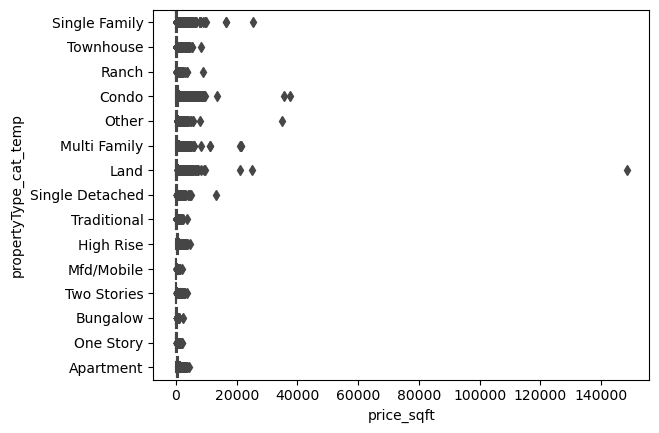

In [72]:
sns.boxplot(x='price_sqft', y='propertyType_cat_temp', data=df);

25 квантиль самого дещевого (за квадрат) объекта недвижимости ('Land') составляет 19,66, но встречаются минимальные цены за квадрат менее 1 доллара. Посмотрим сколько таких объектов (<20$/sqft)

In [73]:
mask_20 = df['price_sqft'] < 20
print('Количество объектов: ', df[mask_20].value_counts().sum())
df[mask_20].sort_values(by=['sqft'])#.head(50)

Количество объектов:  3659


,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat,price_sqft
316592,NaN,Seattle,350.0,98102,WA,1325.0,Apartment,0,0,3.785714
176663,for sale,San Antonio,384.0,78237,TX,7650.0,Land,0,0,19.921875
256459,For sale,Clearwater,480.0,33765,FL,8900.0,Mfd/Mobile,0,0,18.541667
129377,For sale,Flint,484.0,48506,MI,5900.0,Single Family,0,0,12.190083
105281,Active,ST PETE BEACH,500.0,33706,FL,5995.0,Other,0,0,11.990000
...,...,...,...,...,...,...,...,...,...,...
232326,for sale,San Antonio,2807917.0,78255,TX,114900.0,Land,0,0,0.040920
187391,for sale,Panama City,4356000.0,32404,FL,400000.0,Land,0,0,0.091827
52217,for sale,Von Ormy,4356000.0,78073,TX,2000000.0,Land,0,0,0.459137
142148,for sale,Yakima,5728968.0,98901,WA,289000.0,Land,0,0,0.050445


In [74]:
# Из 4537 объектов с ценой < 20$/sqft 919 c подозрительоной ценой 1000. удалим объекты и повторим

mask_1000 = df['target'] == 1000
print('Количество объектов =1000: ', df[df['target'] == 1000]['propertyType_cat_temp'].value_counts().sum())
df.drop(df[df['target'] ==1000].index, inplace = True)

print(f'Результирующее число записей: {df.shape[0]}')

Количество объектов =1000:  0
Результирующее число записей: 320412


У меня не нашлось оснований сделать однозначный вывод, что какая-либо недвижимость не может стоить дешевле, чем <20S/sqft.  
Объектов недвижимости дешевле чем <1S/sqft всего 198, удаляю их из "принципа", не зря же я все это проделал только что...

In [75]:
mask_1 = df['price_sqft'] < 1.00001
print('Количество объектов <1$/sqft: ', df[mask_1].value_counts().sum())
df.drop(df[df['price_sqft'] < 1.00001].index, inplace = True)
print(f'Результирующее число записей: {df.shape[0]}')

Количество объектов <1$/sqft:  198
Результирующее число записей: 320213


In [76]:
mask3 = df['price_sqft'] > 10000
print('Количество объектов: ', df[mask3].value_counts().sum())
df[mask3].sort_values(by=['price_sqft'])

Количество объектов:  15


,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat,price_sqft
294765,for sale,Dallas,600.0,75219,TX,6695000.0,Multi Family,0,0,11158.333333
16568,for sale,New York,1600.0,10012,NY,18000000.0,Multi Family,0,0,11250.000000
88943,Active,Golden Beach,917.0,33160,FL,12200000.0,Single Detached,0,0,13304.252999
267718,for sale,New York,478.0,10012,NY,6500000.0,Condo,0,1,13598.326360
184425,For sale,Sandy Springs,480.0,30342,GA,7850000.0,Single Family,1,0,16354.166667
303946,for sale,Los Angeles,1780.0,90077,CA,29500000.0,Single Family,1,0,16573.033708
204303,for sale,San Diego,380.0,92109,CA,7995000.0,Multi Family,0,0,21039.473684
94024,for sale,Ocala,1854.0,34482,FL,39381010.0,Land,0,1,21241.105717
159515,NaN,Dallas,400.0,75219,TX,8595000.0,Multi Family,0,0,21487.500000
187995,for sale,Dallas,400.0,75219,TX,8595000.0,Multi Family,0,0,21487.500000


у земельного участка в Beverly Hills площадью 741.0 указана цена 148 448.0 за квадрат, что сильно выделяется из ряда других объектов 

In [77]:
mask_BH_c = df['city'] == 'Beverly Hills'
mask_BH_l = df['propertyType_cat_temp'] == 'Land'
print('Количество объектов: ', df[mask_BH_c & mask_BH_l].value_counts().sum())
df[mask_BH_c & mask_BH_l].sort_values(by=['price_sqft'])#.head(50)

Количество объектов:  9


,status,city,sqft,zipcode,state,target,propertyType_cat_temp,PrivatePool_cat,fireplace_cat,price_sqft
215251,for sale,Beverly Hills,2958.0,90210,CA,4495000.0,Land,1,1,1519.607843
112827,for sale,Beverly Hills,2838.0,90210,CA,4495000.0,Land,1,1,1583.861875
286538,for sale,Beverly Hills,15480.0,90210,CA,24950000.0,Land,0,0,1611.757106
86317,for sale,Beverly Hills,2961.0,90210,CA,7495000.0,Land,1,0,2531.239446
248321,for sale,Beverly Hills,1335.0,90210,CA,3500000.0,Land,1,1,2621.722846
91846,for sale,Beverly Hills,3856.0,90210,CA,10650000.0,Land,1,1,2761.929461
141770,for sale,Beverly Hills,3519.0,90210,CA,19975000.0,Land,1,0,5676.328502
228580,for sale,Beverly Hills,3863.0,90210,CA,28000000.0,Land,0,0,7248.252653
354264,for sale,Beverly Hills,741.0,90210,CA,110000000.0,Land,0,0,148448.043185


Таблица данных дает два варианта исправления этой странной цены: 
* удалить один нолик в цене (цена самая большая)
* добавить один нолик к площади (площадь самая маленькая)

не буду, пожалуй угадывать где именно была допущена опечатка - удалю эту строку

In [78]:
df = df.drop (index= 354264 )
print(f'Результирующее число записей: {df.shape[0]}')

Результирующее число записей: 320212


In [79]:
pivot = df.pivot_table(
    values='price_sqft',
    index='state',
    columns='propertyType_cat_temp',
    aggfunc='mean',
)
display(pivot) 

propertyType_cat_temp,Apartment,Bungalow,Condo,High Rise,Land,Mfd/Mobile,Multi Family,One Story,Other,Ranch,Single Detached,Single Family,Townhouse,Traditional,Two Stories
state,,,,,,,,,,,,,,,
AZ,NaN,NaN,154.840763,NaN,NaN,117.551388,NaN,NaN,154.605466,168.095734,NaN,157.576021,NaN,NaN,NaN
BA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.114907,NaN,NaN,NaN,NaN,NaN,NaN
CA,841.293080,NaN,675.016717,NaN,924.363097,139.592507,495.217126,NaN,374.896969,527.417112,NaN,518.411359,464.292522,506.613037,NaN
CO,188.076650,383.719705,322.844839,NaN,589.929564,69.937091,276.114808,NaN,273.625849,NaN,NaN,242.916969,283.393607,243.413215,187.296638
DC,522.186959,455.313882,563.962088,511.055832,410.130487,466.666667,371.753071,NaN,535.645070,286.304398,NaN,395.637121,458.918814,454.424950,NaN
DE,NaN,NaN,355.497015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FL,360.035365,197.185871,360.457050,537.631940,311.556308,78.885776,260.059742,329.791250,252.595850,222.068824,353.344138,222.449979,200.413953,169.830768,501.252236
Fl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.631579,NaN,NaN,NaN,NaN,NaN,NaN
GA,NaN,NaN,283.016669,NaN,234.887915,66.136093,478.537787,NaN,NaN,NaN,NaN,192.407391,205.985292,NaN,NaN


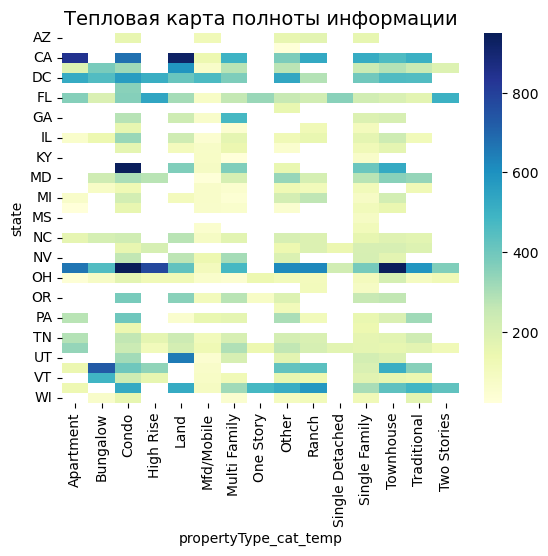

In [80]:
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта полноты информации', fontsize=14);

### предварительные выводы и изменениея в гипотезах
* представленные разрозненные данные не позволяют мне сделать однозначный вывод об удалении всех "выбросов", но самые очевидные удалили. 
* "белая" - практически пустая тепловая карта чуть выше однозначно говорит, что начинать прогнозировать цены с таким количеством отсутсвующих данных смысла нет.  
Поэтому, во-первых, отвергаем гипотезу, что `df['zipcode']` хороший признак местонахождения объекта недвижимости (т.к.более подробный чем Город). Данных слишком мало, чтобы рассматривать варианты даже в пределах штата. Признак `df['zipcode']` можно удалить, так же как и `df['city']`  
Даже для многих Штатов недостаточно данных для учета разбивки по Типам недвижимости. Придется выбрать первые 9-10 штатов (из списка .value_contus()) остальные объеденить в "Other" - хотя это и немного странно. Второй вариант - не использовать штаты "Other" в прогнозе - все равно данные не содержат сведения обо всех Штатах, так пусть их будет не 50, и не 39 (которые упоминаются в df), а скажем, 5-10, с которыми чаще работает данное агентство недвижимости и по которым уже есть исторические данные.  
* во-вторых, деление по "типам недвижимости", которое я сделал - получилось тоже слишком детальное: "One Story", "Single Detached", "Two Stories", "High Rise", "Bungalow" и "Apartment" встречаются слишком редко. Пока склоняюсь к тому, чтобы объеденить эти редко встречающиеся типы недвижимости с другими, сходными по характеристикам, либо вообще отказаться от учета этого признака.  


In [81]:
# посмотрим как у меня объединены типы недвижимости:
df['propertyType_cat_temp'].value_counts(normalize=True)*100

Single Family      56.602501
Condo              17.555245
Other               7.409466
Townhouse           5.630332
Multi Family        3.485503
Traditional         2.626073
Single Detached     1.478708
Land                1.237618
Mfd/Mobile          1.008394
Ranch               0.990906
High Rise           0.596480
One Story           0.548387
Two Stories         0.441270
Apartment           0.234844
Bungalow            0.154273
Name: propertyType_cat_temp, dtype: float64

In [82]:
# присоединим самые редкие к "похожим":
def propertyType_(stroka):
    if stroka == 'Single Family':
        return 'Single Family'
    elif stroka == 'Condo':
        return 'Condo'
    elif stroka == 'Land':
        return 'Land'
    elif stroka == 'Townhouse':
        return 'Townhouse'
    elif stroka == 'Multi Family':
        return 'Multi Family'
    elif stroka == 'Traditional':
        return 'Traditional'
    elif stroka == 'Single Detached':
        return 'Ranch'
    elif stroka == 'Mfd/Mobile':
        return 'Mfd/Mobile'
    elif stroka == 'Ranch':
        return 'Ranch'
    elif stroka == 'High Rise':
        return 'Multi Family'
    elif stroka == 'One Story':
        return 'Ranch'
    elif stroka == 'Two Stories':
        return 'Ranch'
    elif stroka == 'Apartment':
        return 'Multi Family'
    elif stroka == 'Bungalow':
        return 'Ranch'
    else:
        return 'Other'
    
df['propertyType_cat'] = df['propertyType_cat_temp'].apply(propertyType_)
df['propertyType_cat'].value_counts(normalize=True)*100

Single Family    56.602501
Condo            17.555245
Other             7.409466
Townhouse         5.630332
Multi Family      4.316828
Ranch             3.613544
Traditional       2.626073
Land              1.237618
Mfd/Mobile        1.008394
Name: propertyType_cat, dtype: float64

In [83]:
# посмотрим наполненность Штатов данными:
nunique_state = round(df['state'].nunique())# / df['state'].count())#*100,2)
print(f'state Количество уникальных значений: {nunique_state}')
df['state'].value_counts().head(15)

state Количество уникальных значений: 37


FL    96215
TX    74409
CA    21721
NC    17675
NY    17344
TN    14234
WA    12402
OH    10791
NV     7659
IL     7319
CO     5933
GA     5692
PA     5057
DC     4336
MI     3822
Name: state, dtype: int64

In [84]:
# присоединим самые редкие в "Other":
def state_(stroka):
    if stroka == 'FL':
        return 'FL'
    elif stroka == 'TX':
        return 'TX'
    elif stroka == 'CA':
        return 'CA'
    elif stroka == 'NC':
        return 'NC'
    elif stroka == 'NY':
        return 'NY'
    elif stroka == 'TN':
        return 'TN'
    elif stroka == 'WA':
        return 'WA'
    elif stroka == 'OH':
        return 'OH'
    elif stroka == 'MI':
        return 'MI'
    elif stroka == 'IL':
        return 'IL'
    elif stroka == 'CO':
        return 'CO'
    elif stroka == 'DC':
        return 'DC'
    elif stroka == 'PA':
        return 'PA'
    else:
        return 'Other'
    
df['state_cat'] = df['state'].apply(state_)
df['state_cat'].value_counts(normalize=True)*100

FL       30.047281
TX       23.237418
Other     9.042135
CA        6.783319
NC        5.519781
NY        5.416412
TN        4.445180
WA        3.873059
OH        3.369955
IL        2.285673
CO        1.852835
PA        1.579266
DC        1.354103
MI        1.193584
Name: state_cat, dtype: float64

In [85]:
# проверим наличие дубликатов
dupl_columns = len(df) - len(df.drop_duplicates())
print(f'Число найденных дубликатов: {len(df) - len(df.drop_duplicates())}')

Число найденных дубликатов: 4934


In [86]:
# После очистки данных и удаления столбцов, дубликатов сильно прибавилось
# от дубликатов в любом случае надо избавиться
df = df.drop_duplicates(keep='last')
print(f'Результирующее число записей: {df.shape[0]}')

Результирующее число записей: 315278


In [87]:
pivot = df.pivot_table(
    values='price_sqft',
    index='state_cat',
    columns='propertyType_cat',
    aggfunc='count',
)
display(pivot) 

propertyType_cat,Condo,Land,Mfd/Mobile,Multi Family,Other,Ranch,Single Family,Townhouse,Traditional
state_cat,,,,,,,,,
CA,3981.0,165.0,706.0,1997.0,296.0,2.0,13546.0,890.0,11.0
CO,1483.0,36.0,19.0,87.0,698.0,37.0,2814.0,496.0,139.0
DC,1964.0,11.0,2.0,214.0,364.0,13.0,772.0,583.0,276.0
FL,21145.0,915.0,1520.0,3115.0,11749.0,4924.0,46261.0,4391.0,990.0
IL,2686.0,84.0,1.0,677.0,260.0,92.0,3183.0,237.0,55.0
MI,320.0,35.0,24.0,241.0,2.0,2.0,3101.0,72.0,NaN
NC,1247.0,289.0,78.0,105.0,1254.0,396.0,11280.0,1221.0,1539.0
NY,6046.0,104.0,27.0,3768.0,852.0,58.0,5504.0,680.0,88.0
OH,923.0,131.0,35.0,790.0,662.0,557.0,7025.0,60.0,521.0


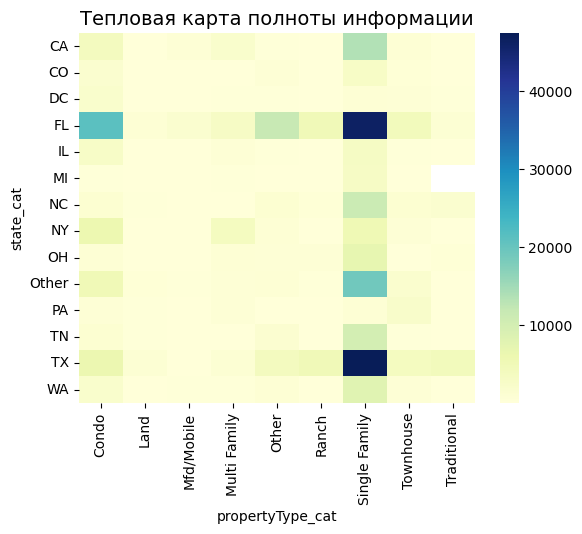

In [88]:
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта полноты информации', fontsize=14);

Ну вот, эксперементальным путем почти избавился от пустоты. Осталось посмотреть как влияет наличие камина и бассейна на стоимость недвижки.  

Но сначала удалим лишние столбцы

In [89]:
backup = df.copy()
backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315278 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   status                 280166 non-null  object 
 1   city                   315274 non-null  object 
 2   sqft                   315278 non-null  float64
 3   zipcode                315278 non-null  object 
 4   state                  315278 non-null  object 
 5   target                 315278 non-null  float64
 6   propertyType_cat_temp  315278 non-null  object 
 7   PrivatePool_cat        315278 non-null  int64  
 8   fireplace_cat          315278 non-null  int64  
 9   price_sqft             315278 non-null  float64
 10  propertyType_cat       315278 non-null  object 
 11  state_cat              315278 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 31.3+ MB


In [91]:
# удаляю после сохранения "обреченные" столбцы
df.drop(['status', 'city', 'zipcode', 'propertyType_cat_temp', 'state',
         'target_log'], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315278 entries, 0 to 377184
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sqft              315278 non-null  float64
 1   target            315278 non-null  float64
 2   PrivatePool_cat   315278 non-null  int64  
 3   fireplace_cat     315278 non-null  int64  
 4   price_sqft        315278 non-null  float64
 5   propertyType_cat  315278 non-null  object 
 6   state_cat         315278 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB


In [93]:
df

,sqft,target,PrivatePool_cat,fireplace_cat,price_sqft,propertyType_cat,state_cat
0,2900.0,418000.0,0,1,144.137931,Single Family,NC
1,1947.0,310000.0,0,0,159.219312,Single Family,WA
2,3000.0,2895000.0,1,1,965.000000,Single Family,CA
3,6457.0,2395000.0,0,1,370.915286,Single Family,TX
5,897.0,209000.0,0,0,232.998885,Townhouse,PA
...,...,...,...,...,...,...,...
377179,1417.0,799000.0,0,0,563.867325,Condo,DC
377180,4017.0,1249000.0,1,0,310.928554,Single Family,FL
377181,2000.0,674999.0,0,0,337.499500,Condo,IL
377182,1152.0,528000.0,0,0,458.333333,Single Family,NY


PrivatePool_cat            0                                                  \
fireplace_cat              0           1           2           3           4   
propertyType_cat                                                               
Condo             427.653797  386.656914  316.913556  320.851031  310.724530   
Land              246.664765  372.318043         NaN         NaN         NaN   
Mfd/Mobile        105.673081  110.910814         NaN         NaN         NaN   
Multi Family      379.000820  347.185104  164.901050         NaN         NaN   
Other             268.678312  264.829585  339.051739  394.567730  433.611984   
Ranch             242.680841  173.695486  217.435735  344.703822  453.742752   
Single Family     198.196615  211.648262  288.654858  366.888477  441.957620   
Townhouse         239.031940  305.165010         NaN         NaN         NaN   
Traditional       185.201190  167.091002  259.457849  302.544043  380.882658   

PrivatePool_cat                        1              
fireplace_cat              5           0           1  
propertyType_cat                                      
Condo             442.366787  517.797614  523.553706  
Land                     NaN  641.573708  331.904206  
Mfd/Mobile               NaN   73.069180  119.678710  
Multi Family             NaN  554.788112  517.787258  
Other             533.167809  276.586816  451.923077  
Ranch             561.313721         NaN         NaN  
Single Family     533.030498  291.314085  325.350107  
Townhouse                NaN  221.912970  253.249964  
Traditional       461.319268         NaN         NaN

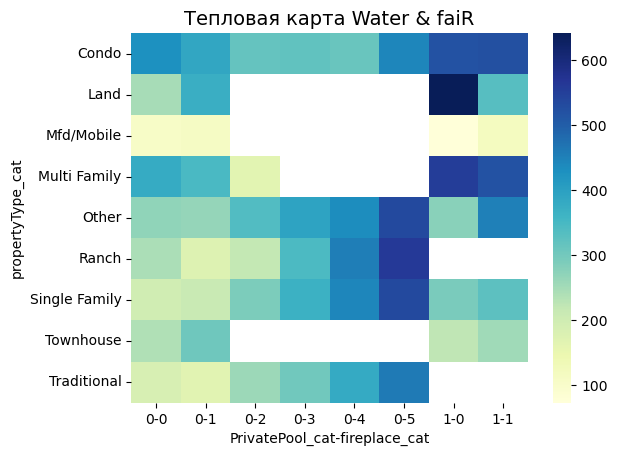

In [94]:
pivot_Water_faiR = df.pivot_table(
    values='price_sqft',
    index='propertyType_cat',
    columns=['PrivatePool_cat', 'fireplace_cat'],
    aggfunc='mean',
)
display(pivot_Water_faiR)
heatmap = sns.heatmap(data=pivot_Water_faiR, cmap='YlGnBu')
heatmap.set_title('Тепловая карта Water & faiR', fontsize=14);

Немного странно видеть камины и бассейны на земельных участках и в мобильных домах, но чаще (кроме "Condo"), цена за квадрат увеличивается при движении слева на право по каждому типу недвижимости, не зря оставлял.

In [95]:
# чтобы не было утечки данных не забыть удалить созданный признак "price_sqft"
# и еще раз, после удаления лишних столбцов проверим наличие дубликатов
df.drop(['price_sqft'], axis = 1, inplace=True)
dupl_columns = len(df) - len(df.drop_duplicates())
print(f'Число найденных дубликатов: {len(df) - len(df.drop_duplicates())}')

Число найденных дубликатов: 30330


Интересно, какой из удаленных недавно признаков так сильно увеличил количество дубликатов? почти 10% появилось, хотя в предыдущие проверки было выявлено всего 4984 дубликата? Или это просто очень похожие объекты?

Я удалил столбцы `'status', 'city', 'zipcode'`, `'propertyType_cat_temp', 'target_log', 'price_sqft'`. Последние три создавались из имеющихся данных, и не могли повлиять на количество дубликатов. Но
* если дубликаты возникли из-за удаления `'status'`, то это действительно могут быть одни и те же объекты недвижимости занесены в df
* если дубликаты возникли из-за удаления `'city', 'zipcode'`, то это могут быть похожие объекты недвижимости в разных городах. Тогжа это не дубликаты.

Придется восстановить данные и проверить:

In [97]:
df_status = backup.copy()
df_status.drop(['city', 'zipcode', 'propertyType_cat_temp', 'target_log', 'price_sqft'], axis = 1, inplace=True)
dupl_columns = len(df_status) - len(df_status.drop_duplicates())
print(f'Число найденных дубликатов: {dupl_columns}')
df_status[df_status.duplicated(keep=False)].sort_values(by=['sqft', 'target']).head(50)

Число найденных дубликатов: 1623


,status,sqft,state,target,PrivatePool_cat,fireplace_cat,propertyType_cat,state_cat
208669,for sale,400.0,NY,175000.0,0,0,Condo,NY
368671,for sale,400.0,NY,175000.0,0,0,Condo,NY
147798,for sale,400.0,NY,235000.0,0,0,Condo,NY
219638,for sale,400.0,NY,235000.0,0,0,Condo,NY
203522,For sale,400.0,NY,375000.0,0,0,Condo,NY
207081,For sale,400.0,NY,375000.0,0,0,Condo,NY
32955,for sale,410.0,FL,139900.0,1,0,Condo,FL
342922,for sale,410.0,FL,139900.0,1,0,Condo,FL
218598,for sale,410.0,FL,165000.0,0,0,Condo,FL
311060,for sale,410.0,FL,165000.0,0,0,Condo,FL


In [122]:
df_adress = backup.copy()
df_adress.drop(['status', 'propertyType_cat_temp', 'target_log', 'price_sqft'], axis = 1, inplace=True)
dupl_columns = len(df_adress) - len(df_adress.drop_duplicates())
print(f'Число найденных дубликатов: {dupl_columns}')
df_adress[df_adress.duplicated(keep=False)].sort_values(by=['sqft', 'target']).head(60)

Число найденных дубликатов: 27169


,city,sqft,zipcode,state,target,PrivatePool_cat,fireplace_cat,propertyType_cat,state_cat
313545,Cape Coral,147.0,33904,FL,339900.0,1,0,Single Family,FL
369132,Cape Coral,147.0,33904,FL,339900.0,1,0,Single Family,FL
158178,Kissimmee,179.0,34758,FL,293385.0,0,0,Single Family,FL
181150,Kissimmee,179.0,34758,FL,293385.0,0,0,Single Family,FL
246051,Bal Harbour,190.0,33154,FL,200000.0,1,0,Condo,FL
336243,Bal Harbour,190.0,33154,FL,200000.0,1,0,Condo,FL
2816,Miami Beach,231.0,33140,FL,127770.0,0,0,Condo,FL
304585,Miami Beach,231.0,33140,FL,127770.0,0,0,Condo,FL
23106,Redington Beach,245.0,33708,FL,149900.0,1,0,Condo,FL
192868,Redington Beach,245.0,33708,FL,149900.0,1,0,Condo,FL


Как неожиданно! дубликаты есть и там и там, причем 27169 дубликатов - из-за того, что риэлтеры дублируют строки, меняя статус.
Печально. До этого момента я удалил менее 62 тысяч строк, и сразу еще 27169. Логично будет оставить последние из повторяющихся строк.

In [123]:
df_all = backup.copy()
df_all.drop(['propertyType_cat_temp', 'target_log', 'price_sqft'], axis = 1, inplace=True)
df_all[df_all.drop('status',axis=1).duplicated(keep=False)].sort_values(by=['sqft', 'target']).head(60)

,status,city,sqft,zipcode,state,target,PrivatePool_cat,fireplace_cat,propertyType_cat,state_cat
313545,For sale,Cape Coral,147.0,33904,FL,339900.0,1,0,Single Family,FL
369132,for sale,Cape Coral,147.0,33904,FL,339900.0,1,0,Single Family,FL
158178,Active,Kissimmee,179.0,34758,FL,293385.0,0,0,Single Family,FL
181150,for sale,Kissimmee,179.0,34758,FL,293385.0,0,0,Single Family,FL
246051,NaN,Bal Harbour,190.0,33154,FL,200000.0,1,0,Condo,FL
336243,for sale,Bal Harbour,190.0,33154,FL,200000.0,1,0,Condo,FL
2816,NaN,Miami Beach,231.0,33140,FL,127770.0,0,0,Condo,FL
304585,for sale,Miami Beach,231.0,33140,FL,127770.0,0,0,Condo,FL
23106,NaN,Redington Beach,245.0,33708,FL,149900.0,1,0,Condo,FL
192868,for sale,Redington Beach,245.0,33708,FL,149900.0,1,0,Condo,FL


In [127]:
df_all[df_all.drop('status',axis=1).duplicated(keep=False)]
df_all.drop(['status'], axis = 1, inplace=True)
df_all = df_all.drop_duplicates(keep='last')
print(f'Результирующее число записей: {df_all.shape[0]}')

Результирующее число записей: 288109


Потренировались. Там где статус не менялся - изменялся Индекс или разное указание названия города (опечатки). Остальные дубликаты придется тоже удалить - это просто дубликаты.

In [130]:
df = df.drop_duplicates(keep='last')
print(f'Результирующее число записей: {df.shape[0]}')
df.info()

Результирующее число записей: 285020
<class 'pandas.core.frame.DataFrame'>
Int64Index: 285020 entries, 0 to 377184
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sqft              285020 non-null  float64
 1   state             285020 non-null  object 
 2   target            285020 non-null  float64
 3   PrivatePool_cat   285020 non-null  int64  
 4   fireplace_cat     285020 non-null  int64  
 5   propertyType_cat  285020 non-null  object 
 6   state_cat         285020 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 17.4+ MB


### Итоги 
у меня осталось 285020 объектов недвижимости (примерно 75,6% от начальной df) и 6 признаков, на основании которых будк делать прогноз цены. Сохраним обработанные данные в файл

In [134]:
data = df.copy()
data.to_csv("data/data_clear.csv") # запись
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285020 entries, 0 to 377184
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sqft              285020 non-null  float64
 1   target            285020 non-null  float64
 2   PrivatePool_cat   285020 non-null  int64  
 3   fireplace_cat     285020 non-null  int64  
 4   propertyType_cat  285020 non-null  object 
 5   state_cat         285020 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 15.2+ MB


In [98]:
df = pd.read_csv("data/data_clear.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285020 entries, 0 to 285019
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        285020 non-null  int64  
 1   sqft              285020 non-null  float64
 2   target            285020 non-null  float64
 3   PrivatePool_cat   285020 non-null  int64  
 4   fireplace_cat     285020 non-null  int64  
 5   propertyType_cat  285020 non-null  object 
 6   state_cat         285020 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 15.2+ MB


### Проверка на нормальность 

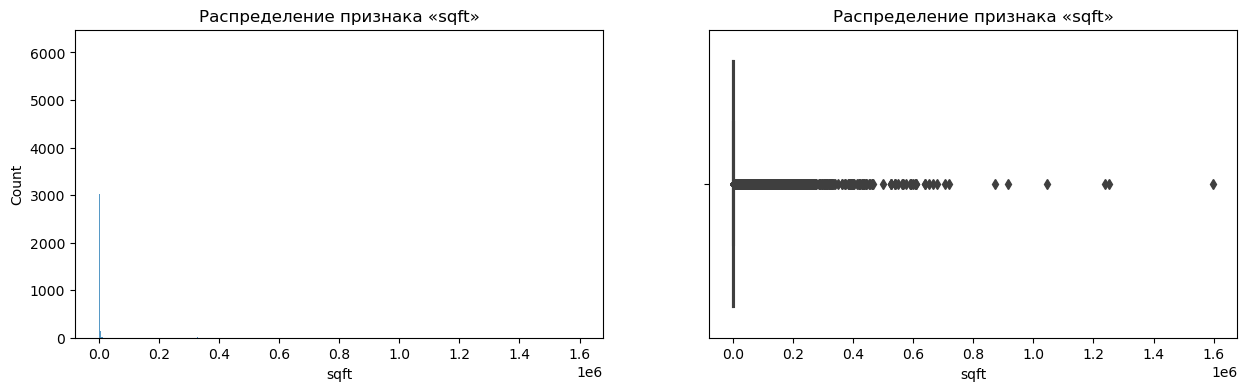

In [3]:
# посмотрим на распределение признака sqft

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='sqft', ax=axes[0]);
histplot.set_title('Распределение признака «sqft»');
# histplot.axvline(df_v14['target'].mean(), color='red', lw=2)

boxplot = sns.boxplot(data=df, x='sqft', ax=axes[1]);
boxplot.set_title('Распределение признака «sqft»');

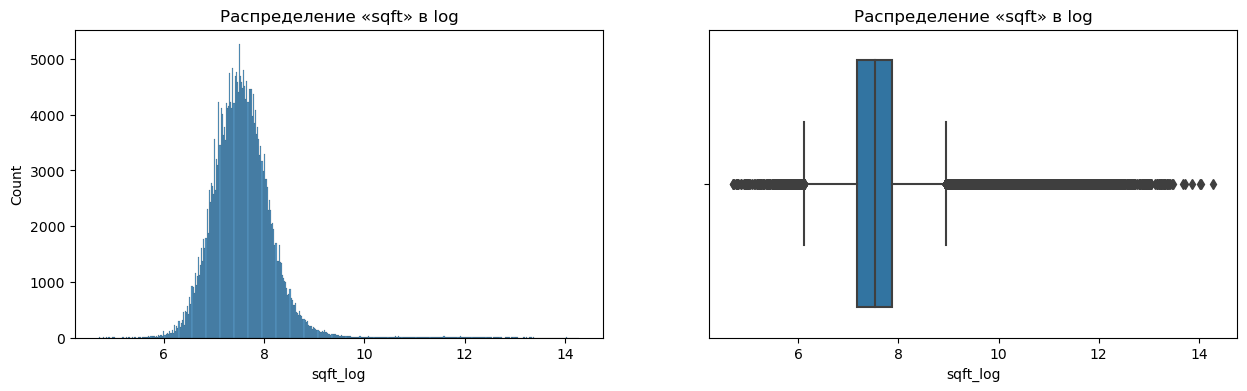

In [5]:
# посмотрим на распределение sqft в логарифмическом масштабе

df['sqft_log'] = np.log(df['sqft']) # смысла прибавлять +1 нету, т.к. нулевых значений нет

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='sqft_log', ax=axes[0]);
histplot.set_title('Распределение «sqft» в log');
boxplot = sns.boxplot(data=df, x='sqft_log', ax=axes[1]);
boxplot.set_title('Распределение «sqft» в log');

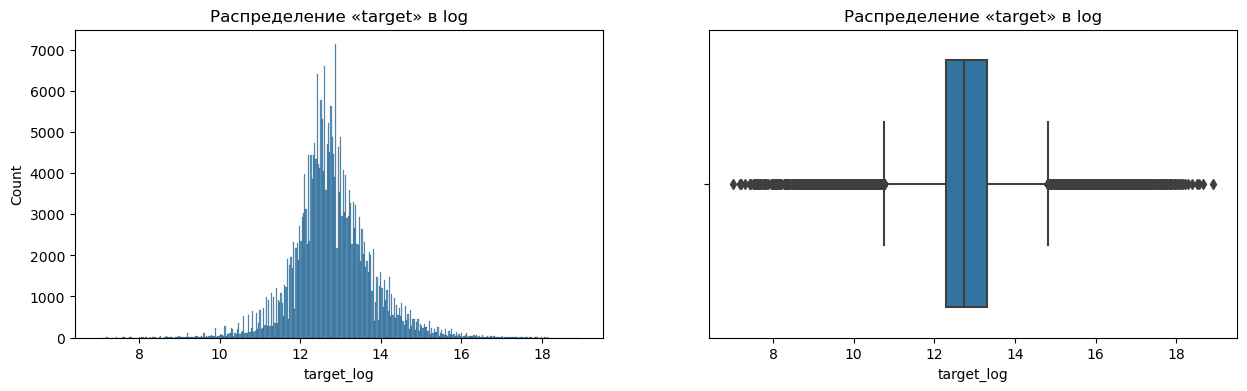

In [102]:
# посмотрим на распределение целевого признака в логарифмическом масштабе после очистки данных

df['target_log'] = np.log(df['target']) # смысла прибавлять +1 нету, т.к. нулевых значений нет

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='target_log', ax=axes[0]);
histplot.set_title('Распределение «target» в log');
boxplot = sns.boxplot(data=df, x='target_log', ax=axes[1]);
boxplot.set_title('Распределение «target» в log');

In [100]:
df.drop(['Unnamed: 0', 'sqft_log'], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285020 entries, 0 to 285019
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sqft              285020 non-null  float64
 1   target            285020 non-null  float64
 2   PrivatePool_cat   285020 non-null  int64  
 3   fireplace_cat     285020 non-null  int64  
 4   propertyType_cat  285020 non-null  object 
 5   state_cat         285020 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 13.0+ MB


### Тест Шапиро-Уилка

In [10]:
# задаём уровень значимости
alpha = 0.05 

# загружаем данные
data = df['target_log']

# проводим тест Шапиро-Уилка
_, p = stats.shapiro(data)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


### Тест Д’Агостино

In [20]:
_, p = stats.normaltest(df.target_log)
#normaltest возвращает двустороннюю вероятность для проверки гипотезы поэтому уровень значимости делим на 2
print('p=%.2f' % p)

if p > 0.05/2:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное')

p=0.00
Распределение не нормальное


In [ ]:
sns.pairplot(df);

### Закодируем категориальные признаки

In [103]:
cols_to_code = ['state_cat','propertyType_cat']
enc = ce.BinaryEncoder(cols=cols_to_code)
df_be = enc.fit_transform(df.drop(['target', 'target_log'], axis=1))
df_be.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285020 entries, 0 to 285019
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sqft                285020 non-null  float64
 1   PrivatePool_cat     285020 non-null  int64  
 2   fireplace_cat       285020 non-null  int64  
 3   propertyType_cat_0  285020 non-null  int64  
 4   propertyType_cat_1  285020 non-null  int64  
 5   propertyType_cat_2  285020 non-null  int64  
 6   propertyType_cat_3  285020 non-null  int64  
 7   state_cat_0         285020 non-null  int64  
 8   state_cat_1         285020 non-null  int64  
 9   state_cat_2         285020 non-null  int64  
 10  state_cat_3         285020 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 23.9 MB


In [104]:
# сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log.

X = df_be
y = df['target']
y_log = df['target_log']

In [105]:
# Разобьём выборку на обучающую и валидационную в соотношении 70/30:

X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)
X_train.shape

(199514, 11)

In [106]:
# рекомендуется масштабировать данные
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [107]:
# линейная регрессия по методу OLS (ordinary least squares).
reg = linear_model.LinearRegression()
reg.fit(X_train_scaled, y_train_log)
y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_pred))))

Train RMSLE score: 0.89
Test RMSLE score: 0.89


In [108]:
# полиномиальные признаки второй степени с помощью PolynomialFeatures

poly = preprocessing.PolynomialFeatures(include_bias=False) # degree=2 по-умолчанию
poly.fit(X_train_scaled)

X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для валидационной выборки
X_test_poly = poly.transform(X_test_scaled)

#Создаём объект класса LinearRegression
reg_poly = linear_model.LinearRegression()
#Обучаем модель 
reg_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = reg_poly.predict(X_train_poly)
#Делаем предсказание для валидационной выборки
y_test_predict_poly = reg_poly.predict(X_test_poly)

# метрики для полиноминальной регрессии
print('Polynomial Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
print('Polynomial Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_poly))))

Polynomial Train RMSLE score: 0.79
Polynomial Test RMSLE score: 0.79


In [109]:
# модель полиномиальной регрессии второй степени с L_2-регуляризацией

#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr = linear_model.Ridge(alpha=0.2) # alpha=1 по-умолчанию
#Обучаем модель
ridge_lr.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly_r = ridge_lr.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly_r = ridge_lr.predict(X_test_poly)
# метрики для полиноминальной регрессии
print('Polynomial-L2 Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly_r))))
print('Polynomial-L2 Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_poly_r))))

Polynomial-L2 Train RMSLE score: 0.79
Polynomial-L2 Test RMSLE score: 0.79


In [110]:
# модель дерева решений

dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train_log)

y_train_predict_dtr = dtr.predict(X_train_scaled)
y_test_predict_dtr = dtr.predict(X_test_scaled)

# метрики для DecisionTreeRegressor
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_dtr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_dtr))))

DecisionTreeRegressor Train RMSLE score: 0.35
DecisionTreeRegressor Test RMSLE score: 0.73


In [111]:
# Задам словарь гиперпараметров для GridSearchCV
param_grid_DTR = {
              'max_depth': list(np.arange(6,21)) # максимальная глубина дерева
              }
#Создаем объект класса            
grid_search_DTR = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(), 
    param_grid=param_grid_DTR,
    n_jobs = -1,
    scoring='neg_mean_squared_error')
# Запускаем подбор гиперпараметров
grid_search_DTR.fit(X_train_scaled, y_train_log) 

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20]},
             scoring='neg_mean_squared_error')

In [112]:
# посмотрим наилучшую найденную комбинацию гиперпараметров
grid_search_DTR.best_params_

{'max_depth': 11}

In [113]:
grid_search_DTR.best_score_
_MSLE = grid_search_DTR.score(X_test_scaled, y_test_log)
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(-_MSLE)))

DecisionTreeRegressor Test RMSLE score: 0.60


In [114]:
# Построим модель случайного леса с найденной нами ранее наилучшим параметром глубины. 

rfr = ensemble.RandomForestRegressor(max_depth=11,
                                  n_estimators=200,
                                  min_samples_split = 20,
                                  random_state=42,
                                    n_jobs = -1)

rfr.fit(X_train_scaled, y_train_log)

y_train_predict_rfr = rfr.predict(X_train_scaled)
y_test_predict_rfr = rfr.predict(X_test_scaled)

# метрики 
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_rfr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_rfr))))


DecisionTreeRegressor Train RMSLE score: 0.57
DecisionTreeRegressor Test RMSLE score: 0.59


In [115]:
# модель градиентного бустинга над деревьями решений (GradientBoostingRegressor)

gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики 
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))


DecisionTreeRegressor Train RMSLE score: 0.57
DecisionTreeRegressor Test RMSLE score: 0.59


In [116]:
# рассчитаю медианную абсолютную ошибку (MeAE, в sklearn — функция median_absolute_error)
y_test = np.exp(y_test_log)
y65_test_predict = np.exp(y_test_predict_gbr)

mae_test = metrics.median_absolute_error(y_test, y65_test_predict)
mae_test

98810.90735284271

In [117]:
df['target'].mean()

639689.0271910743

Средняя медианная ошибка составляет почти 99000S при средней цене недвижимости 640000S "так себе" прогноз. Пожалуй для продакшена его готовить рано - надо дорабатывать. Поэтому на этом предлагаю остановиться